# XCALE Master thesis Data Analysis

In this notebook, we try to explore the data collected with the SRL-Solution on Quick-pi (FRANCE IOI).

<style>.table {margin-left:0px}</style>

## Visualization indicators

We present the different indicators we want to visualize in our gathered data

### Lexical 

| name | Description |
| :--- | :--- |
| **participation** | The set of **connection** of a **participant** and an **activity** |
| **connection** | An event representing the beginning of an activity, the reconnection |
| **participant** | Someone which involves himself in an **activity** |
| **activity** | A set of **sujets** with an 1 hour timing |
| **sujet** | An exercise proposed in different **version** |
| **version** | The difficulty of the exercise, version = {1,2,3,4} |
| **navigation** | An event of navigation between **modules** from the participant |
| **module** | The panel where the participant is, module = {"Aide", "Exercice", "Accueil"} |
| **souris** | An event of mouse between **zone**, movement or state from the participant |
| **zone** | The area where the participant's mouse is located in, zone = {"grid", "controls", "task", "editor"} |
| **prompt** | A questionnaire asked to the user, prompt = {initial, middle, final} |
| **error** | An error done while submitting **validation** or **experimentation**, error = {"Erreur de prérequis" : the program is not executable, "Erreur de solution" : the answer is uncorrect} |
| **validation** | An event of participant succesfulness or not over a sujet-version, submitting his code |
| **experimentation** | An event of participant succesfulness or not over a sujet-version while verifying his code |
| **modification** | An event of participant modifying the **size** of the code |
| **size** | The number of instructions behind the blockly language |

### From User Interaction with Quick-Pi

each of the indicator will be ran over two datasets : 
* From initial prompt to middle prompts traces
* From middle prompt to final prompts traces

| Table | Indicator | Description |
| :--- | :--- | :--- |
| **Participation** |  |  |
|  | **nb_participant** | Number of participants |
| **Connexion** |  |  |  |
|  | **nb_connection_participant** | Number of connections per participant |
|  | **nb_connection_1h** | Number of connections which have done 1h of activity |
|  | **nb_connection_prompts_done** | Number of connections having correctly answered prompts |
| **Navigation** |  |  |
|  | **nb_navigation_connection** | Number of navigation per connection |
|  | **nb_navigation_module_connection** | Number of module's navigation per connection |
|  | **time_navigation_module_connection** | Time spent on module per connection |
| **Validation** |  |  |
|  | **nb_experimentation_connection** | Number of experimentation per connection |
|  | **nb_validation_connection** | Number of validation per connection |
|  | **nb_experimentation_version_connection** | Number of version's experimentation per connection |
|  | **nb_validation_version_connection** | Number of version's validation per connection |
|  | **experimentation_accuracy_connection** | Rate of correct experimentation over uncorrect ones |
|  | **validation_accuracy_connection** | Rate of correct validation over uncorrect ones |
|  | **experimentation_version_accuracy_connection** | Rate of correct experimentation version over uncorrect ones |
|  | **validation_version_accuracy_connection** | Rate of correct validation version over uncorrect ones |
| **Modification** |  |  |
|  | **nb_modification_connection** | Number of modification per connection |
|  | **nb_modification_version_connection** | Number of version's modification per connection |
| **Pas à Pas** |  |  |
|  | **nb_pasapas_connection** | Number of usage of pas à pas per connection|

### From Prompts

| Table | Indicator | Description |
| :--- | :--- | :--- |
| **Prompt Initial** |  |  |
|  | **quickpi_knowledge_participant** | The participant's knowledge of the platform Quick-Pi, estimated by himself |
|  | **coding_knowledge_participant** | The participant's knowledge of his coding skillsi, estimated by himself |
|  | **autonomy_participant** | The participant's autonomy during the activityi, estimated by himself |
|  | **place_participant** | The environment where the participant is located during the activity |
|  | **engagement_participant** | The participant's reason of engagement during the activity |
|  | **initial_objective_participant** | The participant's objective to reach at the end activity |
| **Middle Prompt** |  |  |  |
|  | **motivation_participant** | The participant's interest and motivation during the activityi, estimated by himself |
|  | **middle_time_management_participant** | The participant's quality of time management during the activityi, estimated by himself |
|  | **middle_objective_participant** | The participant's situation regarding his objectivei, estimated by himself |
|  | **new_objective_participant** | The participant's new objective to reach at the end activity |
| **Prompt Final** |  |  |
|  | **final_time_management_participant** | The participant's quality of time management during the activityi, estimated by himself |
|  | **strategy_participant** | The participant's quality of strategy during the activityi, estimated by himself |
|  | **end_objective_participant** | The participant's situation regarding his past objectivei, estimated by himself |

## Dynamic Bayesian network indicators

## Configuration 

### Imports

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn
# data handling
import numpy as np
import pandas as pd
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10

In [2]:
# Database
#!sudo apt-get install python3-dev default-libmysqlclient-dev
!pip install mysql-connector-python
from mysql.connector import connect
# error
import traceback
from collections import defaultdict
from datetime import time, timedelta, datetime
# utilitaries
import functools

     |████████████████████████████████| 25.4MB 117kB/s 


### Database

In [3]:
# Log
_db_config = {
    'user': 'cajuge',
    'password': 'Kz1773qMWIVhRZUZ',
    'host': 'franceioi.cinniket56wn.eu-central-1.rds.amazonaws.com',
    'database': 'srl',
    'port':'3306'
}

In [4]:
_tables = ["clavier", "modification",
          "navigation", "pas_a_pas",
          "souris","srl_final_prompt",
          "srl_initial_prompt","srl_prompt","validation", "connexion"]

In [5]:
def get_connection(config):
    return connect(**config)
def close_connection(connection):
    connection.close()

## Data Import

In [6]:
def getTablesFromDB(min_id_connection, _tables):
    dataframe_tables = {}
    mysql_connection = get_connection(_db_config)
    for table in _tables:
        with mysql_connection.cursor() as cursor:
            try:
                # ----------- Get every connection / participant ---------- #
                filter_column = "id" if table == "connexion" else "id_connexion"
                query_select = "SELECT * FROM {} WHERE {} >= %s ORDER BY {}, timestamp".format(table, filter_column, filter_column)
                cursor.execute(query_select, (min_id_connection,))
                result = cursor.fetchall()
                columns_name = np.array(
                    [cursor.description[i][0] for i in range(len(cursor.description)) if cursor.description[i][0]])
                data = []
                for row in result:
                    data.append(np.array([row[i] for i in range(len(row))]))
                dataframe_tables[table] = pd.DataFrame(data, columns=columns_name)
            except Exception:
                traceback.print_exc()
    return dataframe_tables

In [7]:
dataframe_tables = getTablesFromDB(191, _tables)

In [8]:
dataframe_tables["validation"][dataframe_tables["validation"].id_connexion == 191]

,id,timestamp,score,type_erreur,id_sujet,id_connexion,version,experimentation
0,60,2021-06-08 19:14:52,0,Erreur de solution,23,191,4,0
1,61,2021-06-08 19:16:43,0,Erreur de solution,23,191,4,0
2,62,2021-06-08 19:17:31,0,Erreur de solution,23,191,4,0
3,63,2021-06-08 19:17:49,0,Erreur de solution,23,191,4,0
4,64,2021-06-08 19:18:27,0,Erreur de solution,23,191,4,0
...,...,...,...,...,...,...,...,...
60,121,2021-06-08 20:38:42,0,Erreur de solution,24,191,4,0
61,122,2021-06-08 20:39:06,0,Erreur de solution,24,191,4,0
62,123,2021-06-08 20:39:29,0,Erreur de solution,24,191,4,0
63,124,2021-06-08 20:43:52,0,Erreur de solution,24,191,4,0


## Visualization of Interaction Data with the users

### Participation

#### nb_participant

In [9]:
table = "connexion"

In [10]:
nb_participant = len(set(dataframe_tables[table].id_participation))

In [11]:
print("{} registered participants".format(nb_participant))

3193 registered participants


### Connexion

#### nb_connection_participant

In [12]:
table = "connexion"

In [13]:
nb_connection_participant = pd.DataFrame(dataframe_tables[table].id_participation.value_counts())
nb_connection_participant.columns = ["nb_connection_participant"]

In [14]:
nb_connection_participant

,nb_connection_participant
953,10
985,8
474,7
1277,7
1444,7
...,...
3035,1
986,1
3031,1
982,1


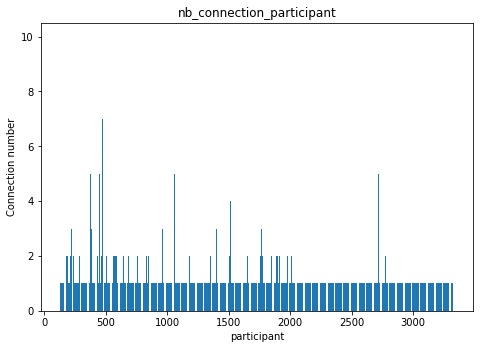

In [15]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
index = nb_connection_participant.index
values = nb_connection_participant.nb_connection_participant
ax.bar(index,values)
ax.set_xlabel('participant')
ax.set_ylabel('Connection number')
ax.set_title('nb_connection_participant')
plt.show()

In [16]:
pd.DataFrame(nb_connection_participant.describe().T)

,count,mean,std,min,25%,50%,75%,max
nb_connection_participant,3193.0,1.186345,0.60907,1.0,1.0,1.0,1.0,10.0


#### nb_connection_1h + at least 1 validation

In [17]:
table = "connexion"

In [18]:
connections = dataframe_tables[table]

In [19]:
nb_connection_1h = []
for j, id_connexion in enumerate(connections.id):
  last_timestamp_table = []
  for table in [i for i in _tables if i != "connexion"]:
    sequence = dataframe_tables[table][dataframe_tables[table].id_connexion == id_connexion].timestamp
    if len(sequence) != 0:
      last_timestamp_table.append(max(sequence))
  if len(last_timestamp_table) != 0:
    if max(last_timestamp_table) - connections.timestamp[j] >= timedelta(hours=1):
      if len(list(dataframe_tables["validation"].query("id_connexion == {}".format(id_connexion)).id)) != 0:
        nb_connection_1h.append(id_connexion)


In [20]:
print("{} registered connections which last at least 1 hour".format(len(nb_connection_1h)))

90 registered connections which last at least 1 hour


#### nb_connection_prompts_done

In [21]:
table = "connexion"

In [22]:
connections = dataframe_tables[table]

In [23]:
nb_connection_prompts_done = []
for j, id_connexion in enumerate(connections.id):
  prompts_connexion = []
  for table in [i for i in _tables if "prompt" in i.split("_")]:
    prompts_connexion.append(dataframe_tables[table][dataframe_tables[table].id_connexion == id_connexion].shape[0] != 0)
  if len(prompts_connexion) != 0:
    if functools.reduce(lambda x, y: x and y, prompts_connexion):
      nb_connection_prompts_done.append(id_connexion)

In [24]:
print("{} registered connections which have done the 3 prompts".format(len(nb_connection_prompts_done)))

0 registered connections which have done the 3 prompts


### Score

for the following indicators, we will only keep the connection which have lasted at least 1 hour (prompts done or not).

#### Classifying Connection by Category of SRL

In [25]:
table = "validation"

In [26]:
def get_cumuled_score(df, ids_connexion):
  cumul_score = []
  for id_connexion in ids_connexion:
    scores = []
    temp_df = df.query('id_connexion == {} and experimentation == 0'.format(id_connexion))
    for id_sujet in list(set(temp_df.id_sujet)):
      ex_temp_df = list(temp_df.query('id_sujet == {} and score != 0'.format(id_sujet)).version)
      versions = np.zeros((5,))
      for row in range(len(ex_temp_df)):
        versions[ex_temp_df[row]] = ex_temp_df[row] * 10
      scores.append(np.max(versions))
    cumul_score.append(np.sum(scores))
  return cumul_score

In [27]:
# give colors to 33 % - 66% - 100% percentile (representing the low, medium, high srl class)
def score_colors(scores):
  colors = []
  per_33 = np.percentile(scores, 33)
  per_66 = np.percentile(scores, 66)
  return ['firebrick' if i <= per_33 else 'gold' if i <= per_66 else 'green' for i in scores]

In [28]:
scores = get_cumuled_score(dataframe_tables[table], nb_connection_1h)
colors = score_colors(scores)

In [29]:
def plotify(title, axis_x, axis_y, x, y, colors):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  indices_label = x
  indices = list(range(len(indices_label)))
  ax.bar(indices, y, color=colors)
  ax.set_xlabel(axis_x)
  ax.set_ylabel(axis_y)
  ax.set_title(title)
  plt.xticks(indices, indices_label, rotation='vertical')

  colors = {'high':'green', 'medium':'gold', 'low':'firebrick'}         
  labels = list(colors.keys())
  handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
  ax.legend(handles, labels)

  plt.show()

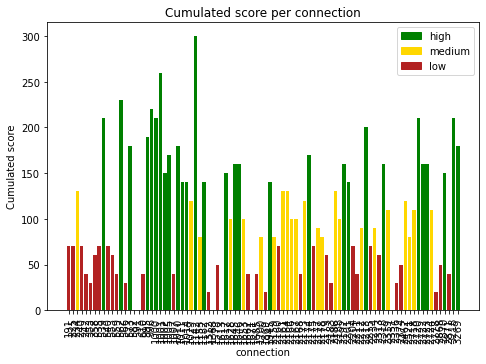

In [30]:
plotify('Cumulated score per connection', 'connection', 'Cumulated score', nb_connection_1h, scores, colors)

#### get each important timestamps (prompts middle or 30 min, promt final or 60 min)

In [31]:
def get_important_timestamps(ids_connexion, df_prompt_middle, df_prompt_final, df_connexion):
  timestamps_middle = []
  timestamps_final = []
  for id_connexion in ids_connexion:
    temp_df = df_prompt_middle.query('id_connexion == {}'.format(id_connexion))
    if temp_df.shape[0] == 0:
      # the user doesn't not provide us prompts
      timestamp = list(df_connexion.query('id == {}'.format(id_connexion)).timestamp)[0]
      timestamps_middle.append(timestamp + timedelta(minutes=30))
      timestamps_final.append(timestamp + timedelta(hours=1))
    else:
      timestamp = list(temp_df.timestamp)[0]
      timestamps_middle.append(timestamp)
      #final
      temp_df = df_prompt_final.query('id_connexion == {}'.format(id_connexion))
      if temp_df.shape[0] == 0:
        # the user doesn't not provide us prompts
        timestamps_final.append(timestamp + timedelta(minutes=30))
      else:
        timestamps_final(list(temp_df.timestamp)[0])
  return [i.to_pydatetime() for i in timestamps_middle], [i.to_pydatetime() for i in timestamps_final]

In [32]:
timestamps_middle, timestamps_final = get_important_timestamps(nb_connection_1h, dataframe_tables["srl_prompt"], dataframe_tables["srl_final_prompt"], dataframe_tables["connexion"])

### Navigation

#### nb_navigation_connection

In [33]:
def count_by_connection_and_prompts(df, cond, nb_connection_1h):
    nb_cond_count = []
    for i, id_connexion in enumerate(nb_connection_1h):
        temp_df = list(df.query("id_connexion == {}".format(id_connexion)).timestamp)
        count = 0
        for row in temp_df:
            if cond == 0 and row <= timestamps_final[i]:
                count += 1
            if cond == 1 and row <= timestamps_middle[i]:
                count += 1
            if cond == 2 and row > timestamps_middle[i] and row <= timestamps_final[i]:
                count += 1
        nb_cond_count.append(count)
    return nb_cond_count

 > total

In [34]:
table = "navigation"

In [35]:
# eliminate unwanted navigation bug on exercice due to quick-pi
nb_navigation_connection_filtered = dataframe_tables[table].query('not(module == "Exercice" and version == 0) and id_connexion in {}'.format(nb_connection_1h))
y = count_by_connection_and_prompts(nb_navigation_connection_filtered, 0, nb_connection_1h)

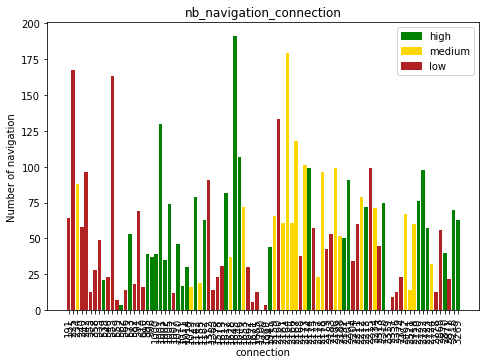

In [36]:
plotify('nb_navigation_connection', 'connection', 'Number of navigation', nb_connection_1h, y, colors)

 > begginning to (middle prompt | 30 minutes)

In [37]:
y = count_by_connection_and_prompts(nb_navigation_connection_filtered, 1, nb_connection_1h)

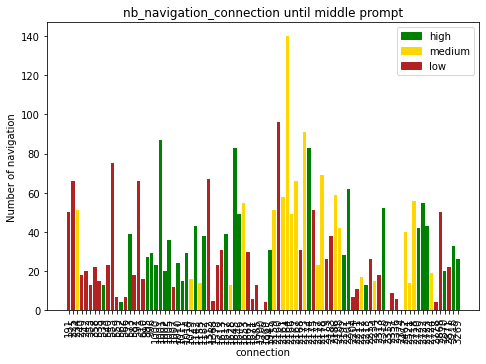

In [38]:
plotify('nb_navigation_connection until middle prompt', 'connection', 'Number of navigation', nb_connection_1h, y, colors)

 > (middle prompt | 30 minutes) to (final prompt | 1 hour)

In [39]:
y = count_by_connection_and_prompts(nb_navigation_connection_filtered, 2, nb_connection_1h)

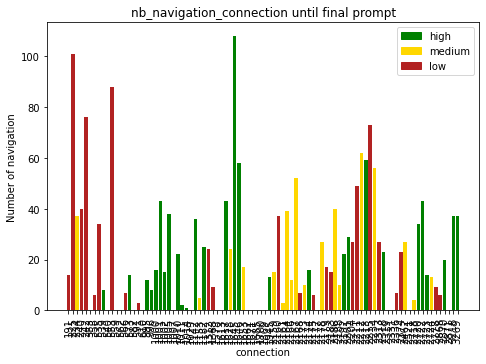

In [40]:
plotify('nb_navigation_connection until final prompt', 'connection', 'Number of navigation', nb_connection_1h, y, colors)

#### nb_navigation_module_connection

 > Exercice Module

In [41]:
table = "navigation"

In [42]:
nb_navigation_module_connection_filter = dataframe_tables[table].query('not(module == "Exercice" and version == 0) and module == "Exercice" and id_connexion in {}'.format(nb_connection_1h))
y1 = count_by_connection_and_prompts(nb_navigation_module_connection_filter, 0, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_navigation_module_connection_filter, 1, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_navigation_module_connection_filter, 2, nb_connection_1h)

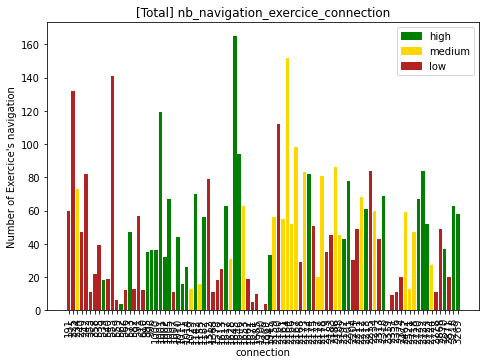

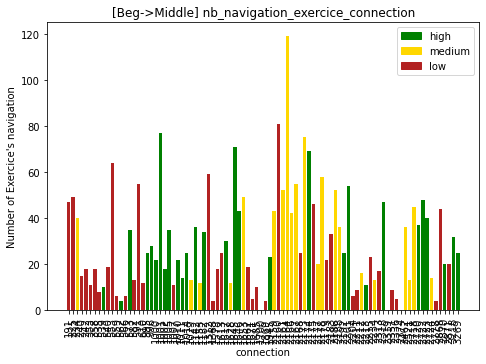

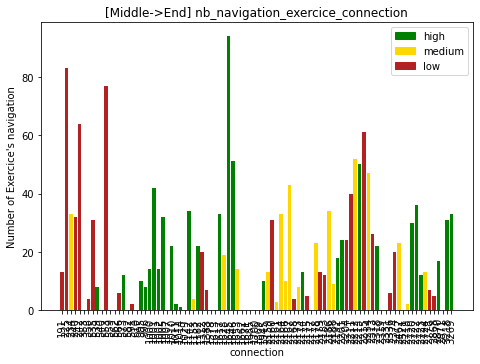

In [43]:
plotify('[Total] nb_navigation_exercice_connection', 'connection', 'Number of Exercice\'s navigation', nb_connection_1h, y1, colors)
plotify('[Beg->Middle] nb_navigation_exercice_connection', 'connection', 'Number of Exercice\'s navigation', nb_connection_1h, y2, colors)
plotify('[Middle->End] nb_navigation_exercice_connection', 'connection', 'Number of Exercice\'s navigation', nb_connection_1h, y3, colors)

 > Aide Module

In [44]:
nb_navigation_module_connection_filter = dataframe_tables[table].query('module == "Aide" and id_connexion in {}'.format(nb_connection_1h))
y1 = count_by_connection_and_prompts(nb_navigation_module_connection_filter, 0, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_navigation_module_connection_filter, 1, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_navigation_module_connection_filter, 2, nb_connection_1h)

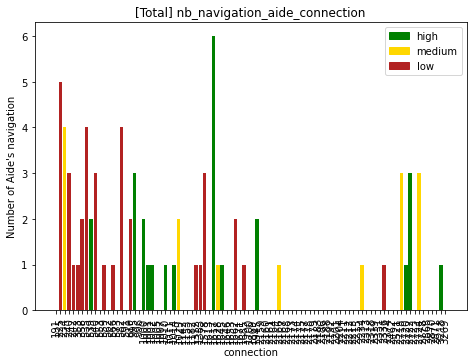

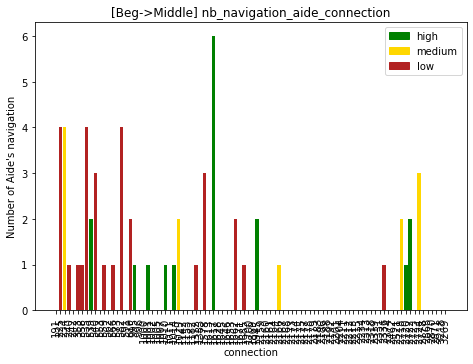

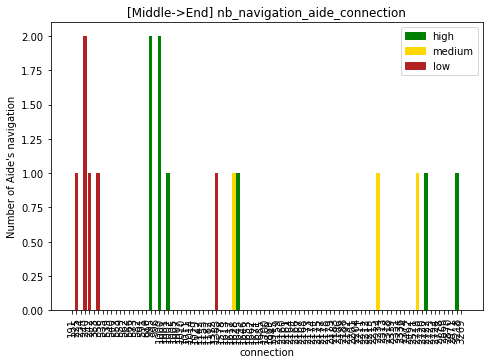

In [45]:
plotify('[Total] nb_navigation_aide_connection', 'connection', 'Number of Aide\'s navigation', nb_connection_1h, y1, colors)
plotify('[Beg->Middle] nb_navigation_aide_connection', 'connection', 'Number of Aide\'s navigation', nb_connection_1h, y2, colors)
plotify('[Middle->End] nb_navigation_aide_connection', 'connection', 'Number of Aide\'s navigation', nb_connection_1h, y3, colors)

 > Accueil Module

In [46]:
nb_navigation_module_connection_filter = dataframe_tables[table].query('module == "Accueil" and id_connexion in {}'.format(nb_connection_1h))
y1 = count_by_connection_and_prompts(nb_navigation_module_connection_filter, 0, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_navigation_module_connection_filter, 1, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_navigation_module_connection_filter, 2, nb_connection_1h)

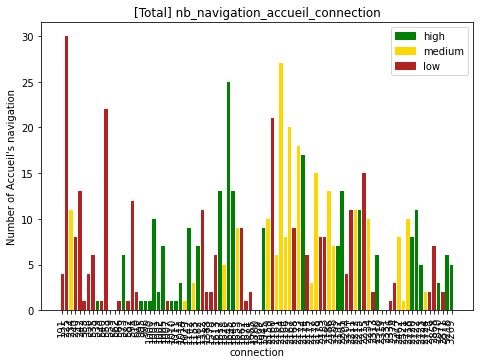

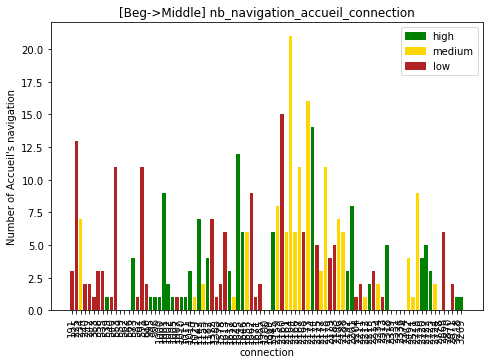

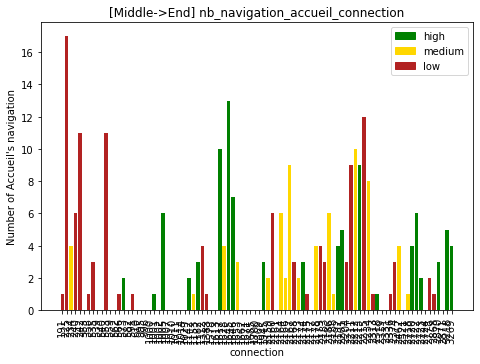

In [47]:
plotify('[Total] nb_navigation_accueil_connection', 'connection', 'Number of Accueil\'s navigation', nb_connection_1h, y1, colors)
plotify('[Beg->Middle] nb_navigation_accueil_connection', 'connection', 'Number of Accueil\'s navigation', nb_connection_1h, y2, colors)
plotify('[Middle->End] nb_navigation_accueil_connection', 'connection', 'Number of Accueil\'s navigation', nb_connection_1h, y3, colors)

#### time_navigation_module_connection

In [48]:
def plotify_timedeltas(title, axis_x, axis_y, x, y, colors):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  indices_label = x
  indices = list(range(len(indices_label)))

  time = [i.total_seconds() for i in y]

  ax.bar(indices, time, color=colors)
  ax.set_xlabel(axis_x)
  ax.set_ylabel(axis_y)
  ax.set_title(title)
  ax.set_xticks(indices)
  ax.set_xticklabels(indices_label)
  ax.set_yticks([i for i in range(0,3601,300)])
  ax.set_yticklabels(["00:00:00","00:05:00","00:10:00","00:15:00","00:20:00","00:25:00","00:30:00","00:35:00","00:40:00","00:45:00","00:50:00","00:55:00","01:00:00"])

  colors = {'high':'green', 'medium':'gold', 'low':'firebrick'}         
  labels = list(colors.keys())
  handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
  ax.legend(handles, labels)
  plt.show()

In [49]:
def time_navigation_module_connection(module, df, nb_connection_1h, timestamps_middle, timestamps_final):
  time_navigation_module_connection_total = []
  time_navigation_module_connection_middle = []
  time_navigation_module_connection_final = []
  for i, id_connexion in enumerate(nb_connection_1h):
    temp_df = list(df.query("id_connexion == {}".format(id_connexion)).timestamp)
    temp_df_module = list(df.query("id_connexion == {}".format(id_connexion)).module)
    count1 = timedelta(0)
    count2 = timedelta(0)
    count3 = timedelta(0)
    for j, row in enumerate(temp_df):
      if temp_df_module[j] == module:
        cond1 = row <= timestamps_final[i]
        cond2 = row <= timestamps_middle[i]
        cond3 = row > timestamps_middle[i]
        cond4 = (cond3 and cond1) or cond2
        # total
        if cond1:
          temp = row.to_pydatetime()
          if j == len(temp_df) - 1:
            temp = timestamps_final[i] - temp
          else:
            if temp_df[j+1].to_pydatetime() > timestamps_final[i]:
              temp = timestamps_final[i] - temp
            else:
              temp = temp_df[j+1].to_pydatetime() - temp
          count1 += temp
        # middle
        if row <= timestamps_middle[i]:
          temp = row.to_pydatetime()
          if j == len(temp_df) - 1:
            temp = timestamps_middle[i] - temp
          else:
            if temp_df[j+1].to_pydatetime() > timestamps_middle[i]:
              temp = timestamps_middle[i] - temp
            else:
              temp = temp_df[j+1].to_pydatetime() - temp
          count2 += temp
        # final
        if cond4:
          temp = row.to_pydatetime()
          if (cond3 and cond1):
            if j == len(temp_df) - 1:
              temp = timestamps_final[i] - temp
            else:
              if temp_df[j+1].to_pydatetime() > timestamps_final[i]:
                temp = timestamps_final[i] - temp
              else:
                temp = temp_df[j+1].to_pydatetime() - temp
            count3 += temp
          else:
            if j == len(temp_df) - 1:
              temp = timestamps_final[i] - timestamps_middle[i]
              count3 += temp
            else:
              if temp_df[j+1].to_pydatetime() > timestamps_middle[i]:
                if temp_df[j+1].to_pydatetime() > timestamps_final[i]:
                  temp = timestamps_final[i] - timestamps_middle[i]
                else:
                  temp = temp_df[j+1].to_pydatetime() - timestamps_middle[i]
                count3 += temp
    time_navigation_module_connection_total.append(count1)
    time_navigation_module_connection_middle.append(count2)
    time_navigation_module_connection_final.append(count3)
  return time_navigation_module_connection_total, time_navigation_module_connection_middle, time_navigation_module_connection_final


 > Exercice Module

In [50]:
time_navigation_module_connection_filter = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h))

In [51]:
y1, y2, y3 = time_navigation_module_connection("Exercice", time_navigation_module_connection_filter, nb_connection_1h, timestamps_middle, timestamps_final)

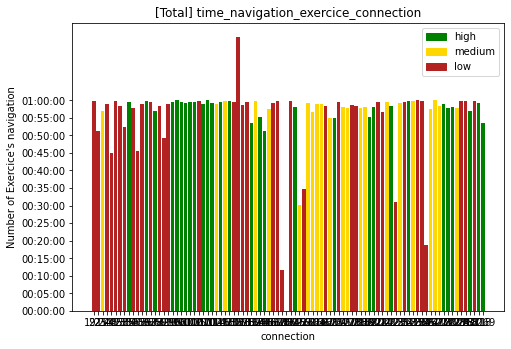

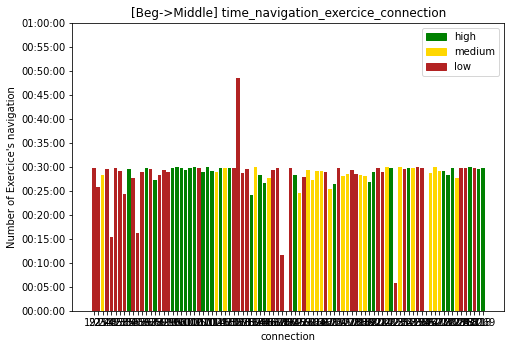

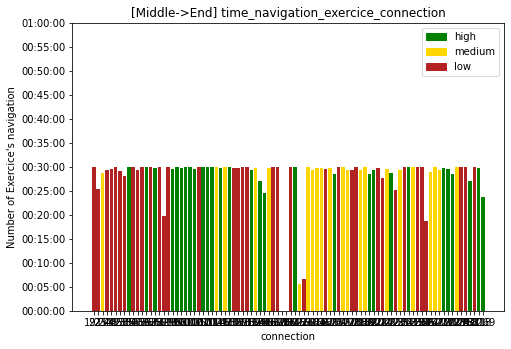

In [52]:
plotify_timedeltas('[Total] time_navigation_exercice_connection', 'connection', 'Number of Exercice\'s navigation', nb_connection_1h, y1, colors)
plotify_timedeltas('[Beg->Middle] time_navigation_exercice_connection', 'connection', 'Number of Exercice\'s navigation', nb_connection_1h, y2, colors)
plotify_timedeltas('[Middle->End] time_navigation_exercice_connection', 'connection', 'Number of Exercice\'s navigation', nb_connection_1h, y3, colors)

 > Aide Module

In [53]:
time_navigation_module_connection_filter = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h))

In [54]:
y1, y2, y3 = time_navigation_module_connection("Aide", time_navigation_module_connection_filter, nb_connection_1h, timestamps_middle, timestamps_final)

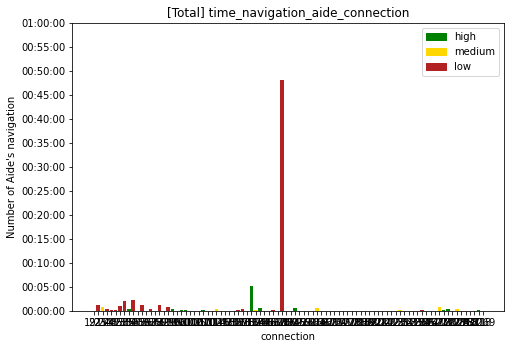

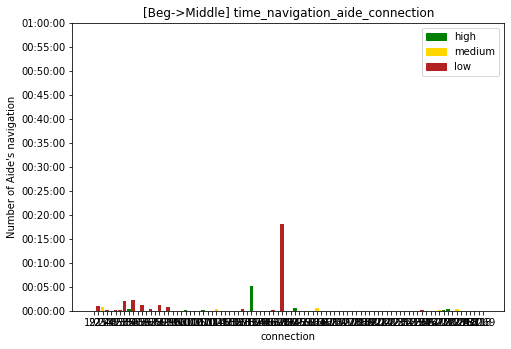

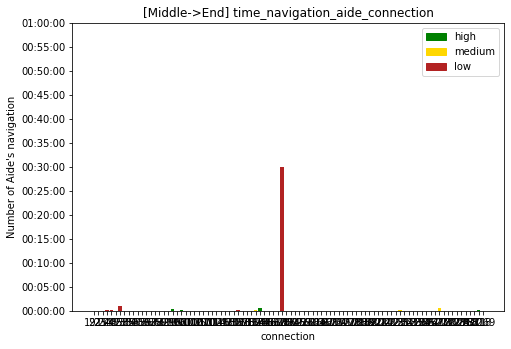

In [55]:
plotify_timedeltas('[Total] time_navigation_aide_connection', 'connection', 'Number of Aide\'s navigation', nb_connection_1h, y1, colors)
plotify_timedeltas('[Beg->Middle] time_navigation_aide_connection', 'connection', 'Number of Aide\'s navigation', nb_connection_1h, y2, colors)
plotify_timedeltas('[Middle->End] time_navigation_aide_connection', 'connection', 'Number of Aide\'s navigation', nb_connection_1h, y3, colors)

 > Accueil Module

In [56]:
time_navigation_module_connection_filter = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h))

In [57]:
y1, y2, y3 = time_navigation_module_connection("Accueil", time_navigation_module_connection_filter, nb_connection_1h, timestamps_middle, timestamps_final)

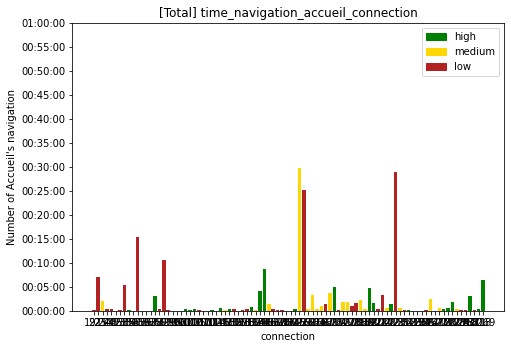

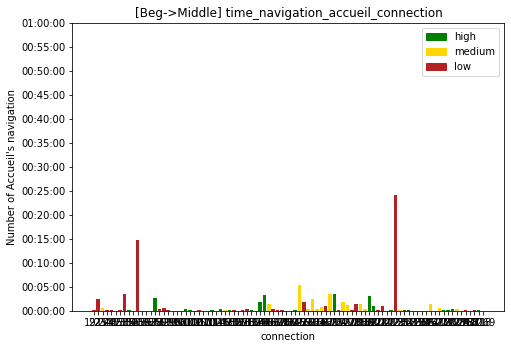

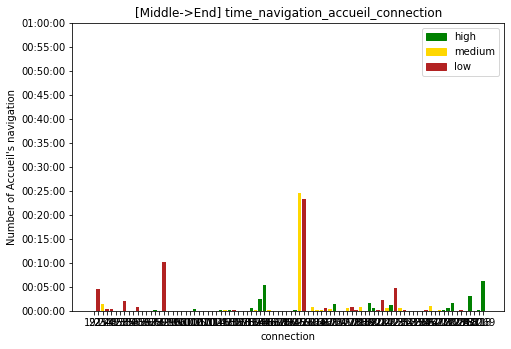

In [58]:
plotify_timedeltas('[Total] time_navigation_accueil_connection', 'connection', 'Number of Accueil\'s navigation', nb_connection_1h, y1, colors)
plotify_timedeltas('[Beg->Middle] time_navigation_accueil_connection', 'connection', 'Number of Accueil\'s navigation', nb_connection_1h, y2, colors)
plotify_timedeltas('[Middle->End] time_navigation_accueil_connection', 'connection', 'Number of Accueil\'s navigation', nb_connection_1h, y3, colors)

### Validation

#### nb_experimentation_connection

In [59]:
table = "validation"

In [60]:
nb_experimentation_connection_filter = dataframe_tables[table].query('id_connexion in {} and experimentation == 1'.format(nb_connection_1h))

 > Total

In [61]:
y = count_by_connection_and_prompts(nb_experimentation_connection_filter, 0, nb_connection_1h)

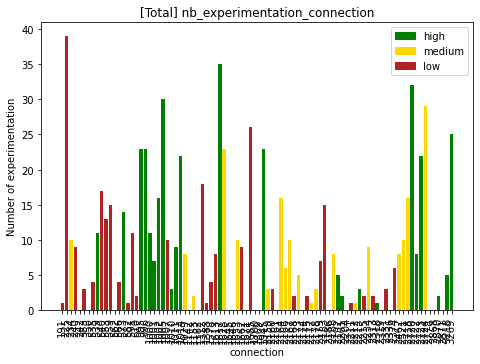

In [62]:
plotify('[Total] nb_experimentation_connection', 'connection', 'Number of experimentation', nb_connection_1h, y, colors)

 > Middle Prompt

In [63]:
y = count_by_connection_and_prompts(nb_experimentation_connection_filter, 1, nb_connection_1h)

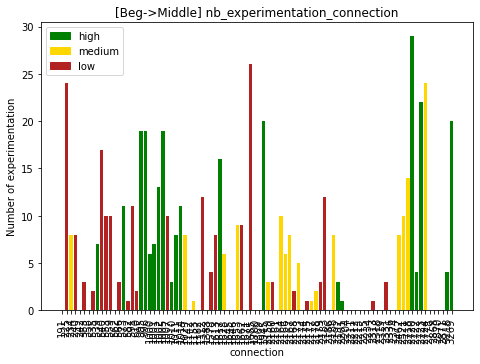

In [64]:
plotify('[Beg->Middle] nb_experimentation_connection', 'connection', 'Number of experimentation', nb_connection_1h, y, colors)

 > Final Prompt

In [65]:
y = count_by_connection_and_prompts(nb_experimentation_connection_filter, 2, nb_connection_1h)

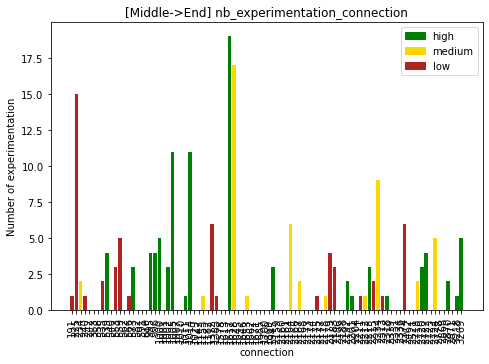

In [66]:
plotify('[Middle->End] nb_experimentation_connection', 'connection', 'Number of experimentation', nb_connection_1h, y, colors)

#### nb_validation_connection

In [67]:
table = "validation"

In [68]:
nb_validation_connection_filter = dataframe_tables[table].query('id_connexion in {} and experimentation == 0'.format(nb_connection_1h))

 > Total

In [69]:
y = count_by_connection_and_prompts(nb_validation_connection_filter, 0, nb_connection_1h)

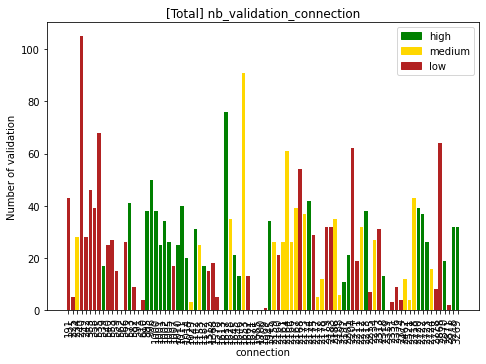

In [70]:
plotify('[Total] nb_validation_connection', 'connection', 'Number of validation', nb_connection_1h, y, colors)

 > Middle Prompt

In [71]:
y = count_by_connection_and_prompts(nb_validation_connection_filter, 1, nb_connection_1h)

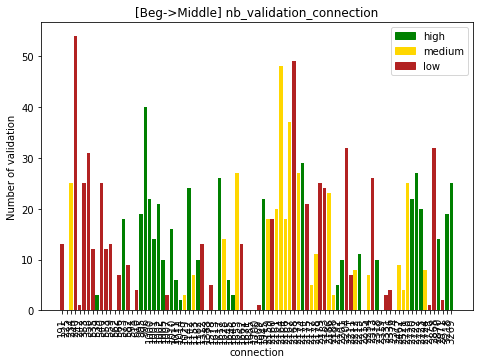

In [72]:
plotify('[Beg->Middle] nb_validation_connection', 'connection', 'Number of validation', nb_connection_1h, y, colors)

 > Final Prompt

In [73]:
y = count_by_connection_and_prompts(nb_validation_connection_filter, 2, nb_connection_1h)

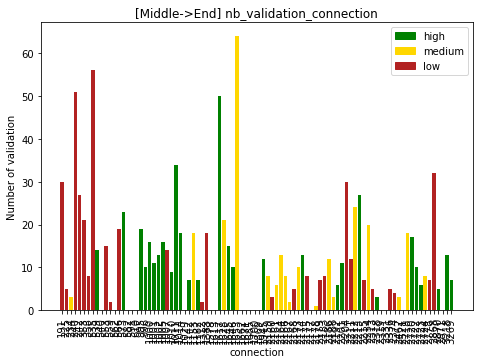

In [74]:
plotify('[Middle->End] nb_validation_connection', 'connection', 'Number of validation', nb_connection_1h, y, colors)

#### nb_experimentation_version_connection

In [75]:
table = "validation"

In [76]:
nb_experimentation_version_connection_filter_1 = dataframe_tables[table].query('id_connexion in {} and experimentation == 1 and version == 1'.format(nb_connection_1h))
nb_experimentation_version_connection_filter_2 = dataframe_tables[table].query('id_connexion in {} and experimentation == 1 and version == 2'.format(nb_connection_1h))
nb_experimentation_version_connection_filter_3 = dataframe_tables[table].query('id_connexion in {} and experimentation == 1 and version == 3'.format(nb_connection_1h))
nb_experimentation_version_connection_filter_4 = dataframe_tables[table].query('id_connexion in {} and experimentation == 1 and version == 4'.format(nb_connection_1h))

 > Total

In [77]:
y1 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_1, 0, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_2, 0, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_3, 0, nb_connection_1h)
y4 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_4, 0, nb_connection_1h)

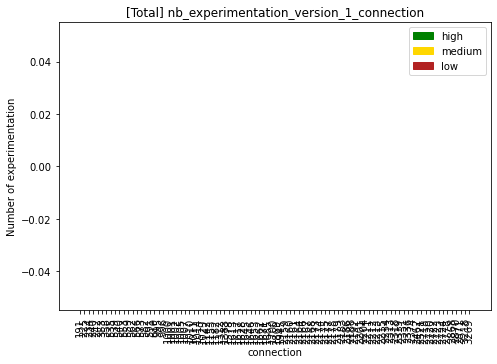

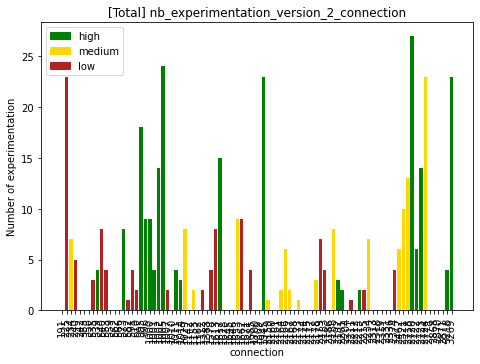

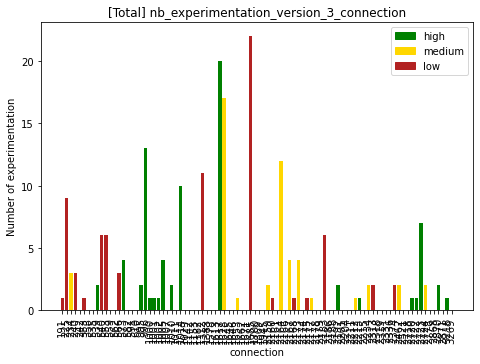

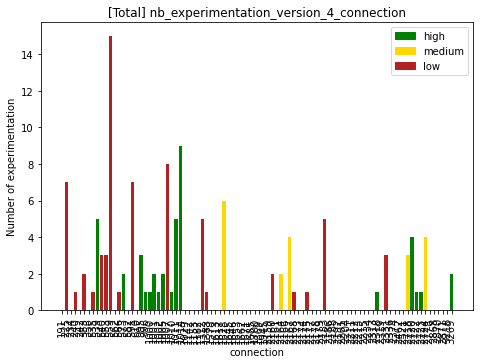

In [78]:
plotify('[Total] nb_experimentation_version_1_connection', 'connection', 'Number of experimentation', nb_connection_1h, y1, colors)
plotify('[Total] nb_experimentation_version_2_connection', 'connection', 'Number of experimentation', nb_connection_1h, y2, colors)
plotify('[Total] nb_experimentation_version_3_connection', 'connection', 'Number of experimentation', nb_connection_1h, y3, colors)
plotify('[Total] nb_experimentation_version_4_connection', 'connection', 'Number of experimentation', nb_connection_1h, y4, colors)

 > Middle Prompt

In [79]:
y1 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_1, 1, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_2, 1, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_3, 1, nb_connection_1h)
y4 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_4, 1, nb_connection_1h)

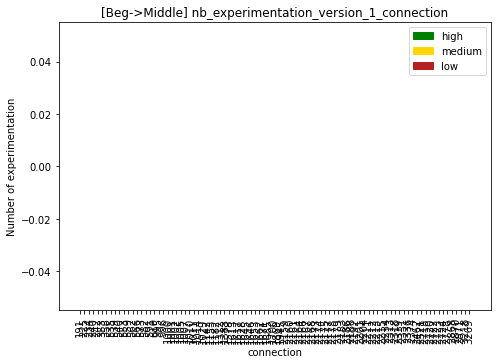

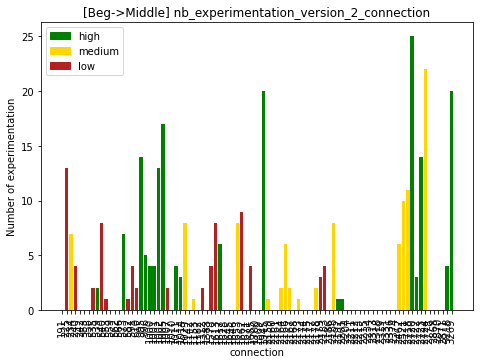

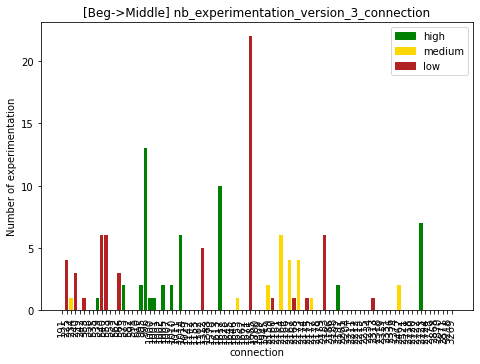

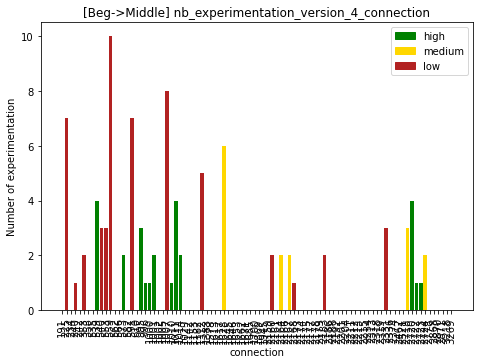

In [80]:
plotify('[Beg->Middle] nb_experimentation_version_1_connection', 'connection', 'Number of experimentation', nb_connection_1h, y1, colors)
plotify('[Beg->Middle] nb_experimentation_version_2_connection', 'connection', 'Number of experimentation', nb_connection_1h, y2, colors)
plotify('[Beg->Middle] nb_experimentation_version_3_connection', 'connection', 'Number of experimentation', nb_connection_1h, y3, colors)
plotify('[Beg->Middle] nb_experimentation_version_4_connection', 'connection', 'Number of experimentation', nb_connection_1h, y4, colors)

 > Final Prompt

In [81]:
y1 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_1, 2, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_2, 2, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_3, 2, nb_connection_1h)
y4 = count_by_connection_and_prompts(nb_experimentation_version_connection_filter_4, 2, nb_connection_1h)

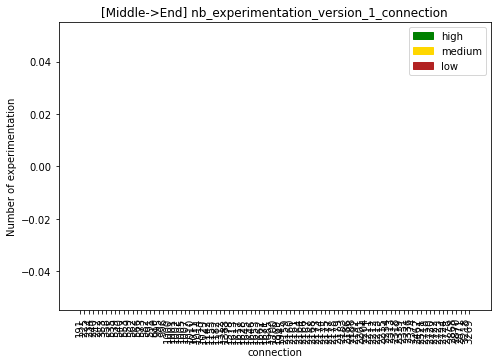

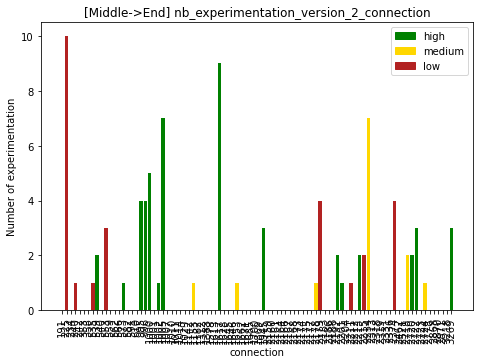

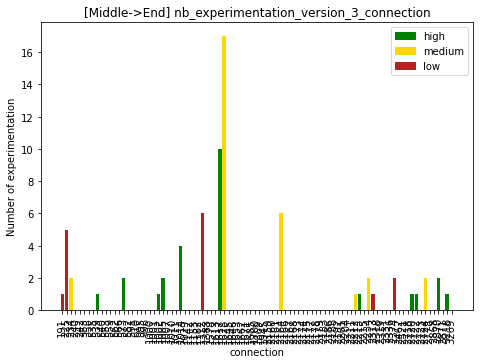

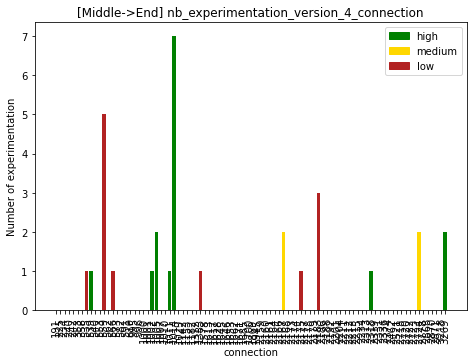

In [82]:
plotify('[Middle->End] nb_experimentation_version_1_connection', 'connection', 'Number of experimentation', nb_connection_1h, y1, colors)
plotify('[Middle->End] nb_experimentation_version_2_connection', 'connection', 'Number of experimentation', nb_connection_1h, y2, colors)
plotify('[Middle->End] nb_experimentation_version_3_connection', 'connection', 'Number of experimentation', nb_connection_1h, y3, colors)
plotify('[Middle->End] nb_experimentation_version_4_connection', 'connection', 'Number of experimentation', nb_connection_1h, y4, colors)

#### nb_validation_version_connection

In [83]:
table = "validation"

In [84]:
nb_validation_version_connection_filter_1 = dataframe_tables[table].query('id_connexion in {} and experimentation == 0 and version == 1'.format(nb_connection_1h))
nb_validation_version_connection_filter_2 = dataframe_tables[table].query('id_connexion in {} and experimentation == 0 and version == 2'.format(nb_connection_1h))
nb_validation_version_connection_filter_3 = dataframe_tables[table].query('id_connexion in {} and experimentation == 0 and version == 3'.format(nb_connection_1h))
nb_validation_version_connection_filter_4 = dataframe_tables[table].query('id_connexion in {} and experimentation == 0 and version == 4'.format(nb_connection_1h))

 > Total

In [85]:
y1 = count_by_connection_and_prompts(nb_validation_version_connection_filter_1, 0, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_validation_version_connection_filter_2, 0, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_validation_version_connection_filter_3, 0, nb_connection_1h)
y4 = count_by_connection_and_prompts(nb_validation_version_connection_filter_4, 0, nb_connection_1h)

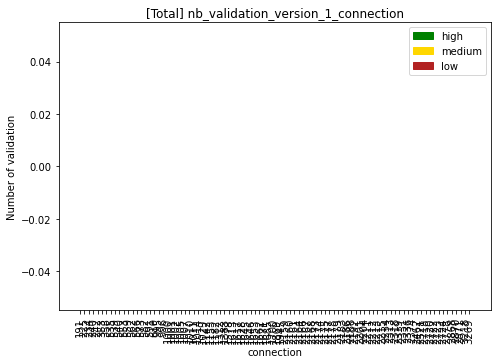

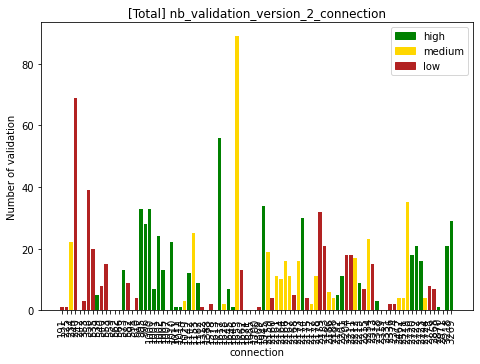

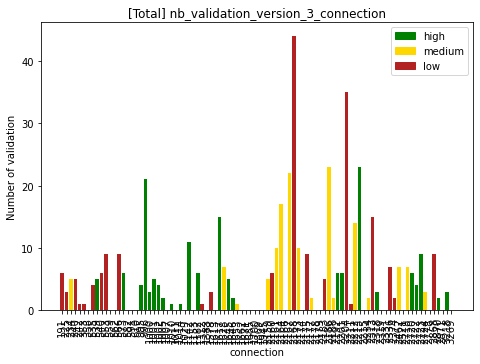

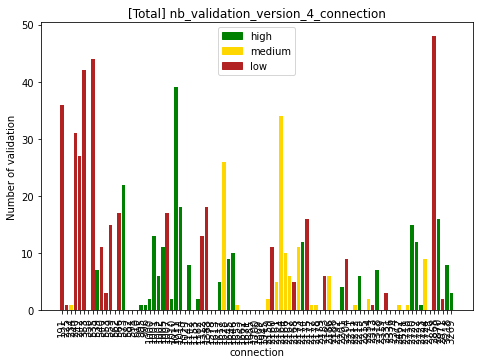

In [86]:
plotify('[Total] nb_validation_version_1_connection', 'connection', 'Number of validation', nb_connection_1h, y1, colors)
plotify('[Total] nb_validation_version_2_connection', 'connection', 'Number of validation', nb_connection_1h, y2, colors)
plotify('[Total] nb_validation_version_3_connection', 'connection', 'Number of validation', nb_connection_1h, y3, colors)
plotify('[Total] nb_validation_version_4_connection', 'connection', 'Number of validation', nb_connection_1h, y4, colors)

 > Middle Prompt

In [87]:
y1 = count_by_connection_and_prompts(nb_validation_version_connection_filter_1, 1, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_validation_version_connection_filter_2, 1, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_validation_version_connection_filter_3, 1, nb_connection_1h)
y4 = count_by_connection_and_prompts(nb_validation_version_connection_filter_4, 1, nb_connection_1h)

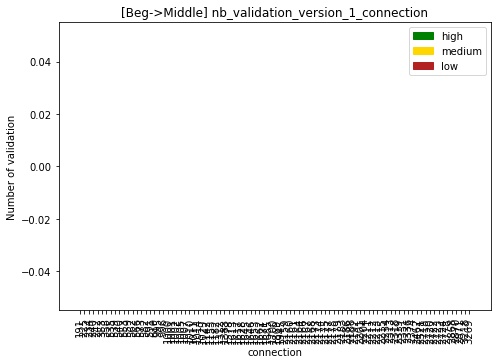

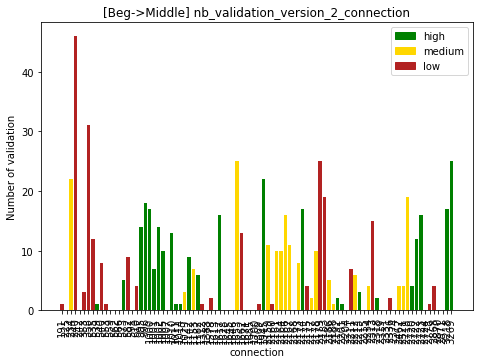

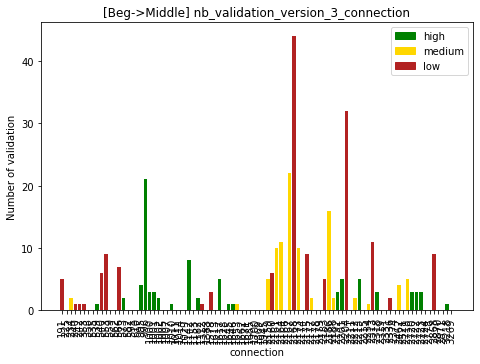

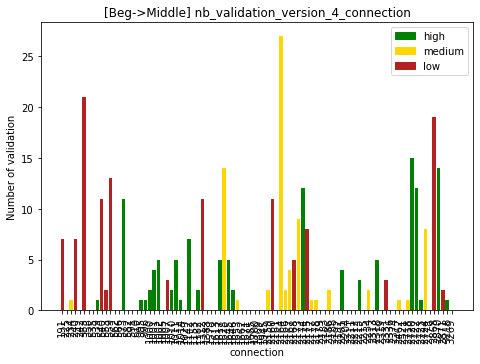

In [88]:
plotify('[Beg->Middle] nb_validation_version_1_connection', 'connection', 'Number of validation', nb_connection_1h, y1, colors)
plotify('[Beg->Middle] nb_validation_version_2_connection', 'connection', 'Number of validation', nb_connection_1h, y2, colors)
plotify('[Beg->Middle] nb_validation_version_3_connection', 'connection', 'Number of validation', nb_connection_1h, y3, colors)
plotify('[Beg->Middle] nb_validation_version_4_connection', 'connection', 'Number of validation', nb_connection_1h, y4, colors)

 > Final Prompt

In [89]:
y1 = count_by_connection_and_prompts(nb_validation_version_connection_filter_1, 2, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_validation_version_connection_filter_2, 2, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_validation_version_connection_filter_3, 2, nb_connection_1h)
y4 = count_by_connection_and_prompts(nb_validation_version_connection_filter_4, 2, nb_connection_1h)

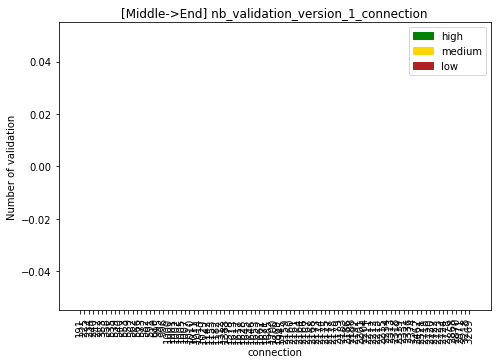

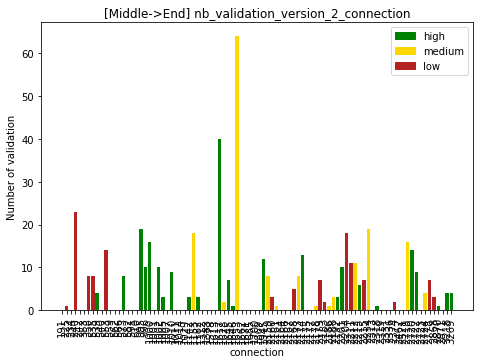

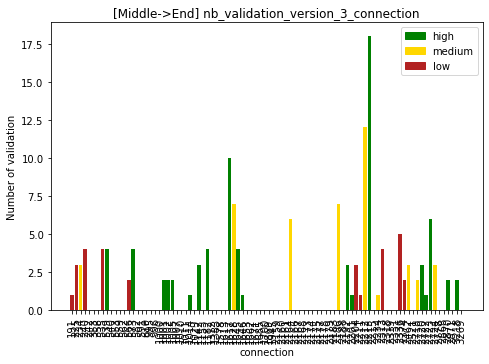

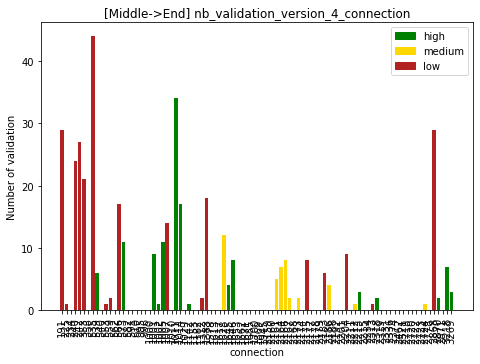

In [90]:
plotify('[Middle->End] nb_validation_version_1_connection', 'connection', 'Number of validation', nb_connection_1h, y1, colors)
plotify('[Middle->End] nb_validation_version_2_connection', 'connection', 'Number of validation', nb_connection_1h, y2, colors)
plotify('[Middle->End] nb_validation_version_3_connection', 'connection', 'Number of validation', nb_connection_1h, y3, colors)
plotify('[Middle->End] nb_validation_version_4_connection', 'connection', 'Number of validation', nb_connection_1h, y4, colors)

#### experimentation_accuracy_connection

In [91]:
def count_by_exp_acc_connection_and_prompts(df, cond, nb_connection_1h):
    count_rates = []
    for i, id_connexion in enumerate(nb_connection_1h):
        temp_df = df.query("id_connexion == {}".format(id_connexion))
        exp_correct = list(temp_df.query("type_erreur == 'Aucune'").timestamp)
        exp_not_correct = list(temp_df.query("type_erreur != 'Aucune'").timestamp)
        count_c = 0
        count_not_c = 0
        for row in exp_correct:
            if cond == 0 and row <= timestamps_final[i]:
                count_c += 1
            if cond == 1 and row <= timestamps_middle[i]:
                count_c += 1
            if cond == 2 and row > timestamps_middle[i] and row <= timestamps_final[i]:
                count_c += 1
        for row in exp_not_correct:
            if cond == 0 and row <= timestamps_final[i]:
                count_not_c += 1
            if cond == 1 and row <= timestamps_middle[i]:
                count_not_c += 1
            if cond == 2 and row > timestamps_middle[i] and row <= timestamps_final[i]:
                count_not_c += 1
        count_rates.append((count_c, count_not_c))
    return count_rates

In [92]:
def plotify_rate(title, axis_x, axis_y, x, y, colors):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    width = 0.35
    indices_label = x
    indices = np.arange(len(indices_label))
    ax.bar(indices - width/2, [i[0] for i in y],  width=width, color=colors)
    ax.bar(indices + width/2, [i[1] for i in y], width=width, color=colors)
    ax.set_xlabel(axis_x)
    ax.set_ylabel(axis_y)
    ax.set_title(title)
    plt.xticks(indices, indices_label, rotation="vertical")
    colors = {'high':'green', 'medium':'gold', 'low':'firebrick'}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    ax.legend(handles, labels)

    plt.show()

In [93]:
table = "validation"

In [94]:
experimentation_accuracy_connection_filter = dataframe_tables[table].query('id_connexion in {} and experimentation == 1'.format(nb_connection_1h))

 > Total

In [95]:
y = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter, 0, nb_connection_1h)
y_rate = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y]

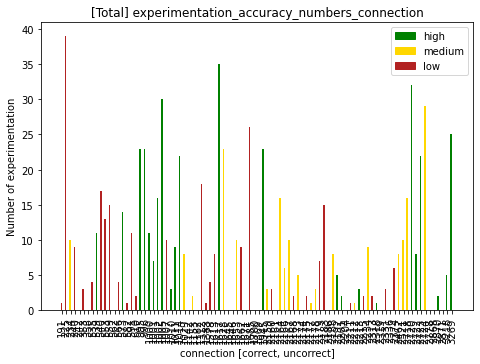

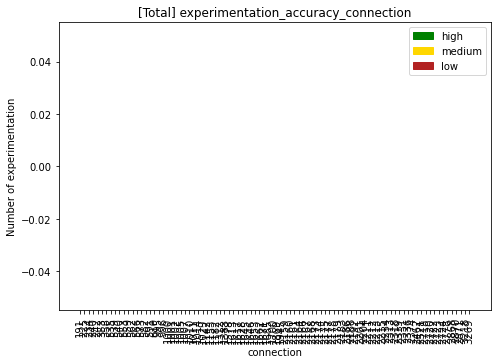

In [96]:
plotify_rate('[Total] experimentation_accuracy_numbers_connection', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y, colors)
plotify('[Total] experimentation_accuracy_connection', 'connection', 'Number of experimentation', nb_connection_1h, y_rate, colors)

 > Middle Prompt

In [97]:
y = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter, 1, nb_connection_1h)
y_rate = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y]

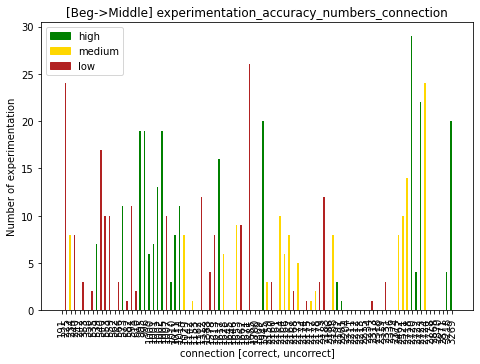

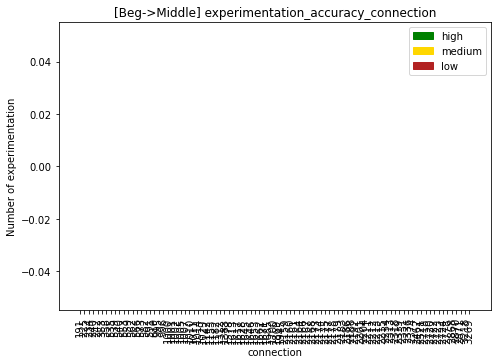

In [98]:
plotify_rate('[Beg->Middle] experimentation_accuracy_numbers_connection', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y, colors)
plotify('[Beg->Middle] experimentation_accuracy_connection', 'connection', 'Number of experimentation', nb_connection_1h, y_rate, colors)

 > Final prompt

In [99]:
y = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter, 2, nb_connection_1h)
y_rate = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y]

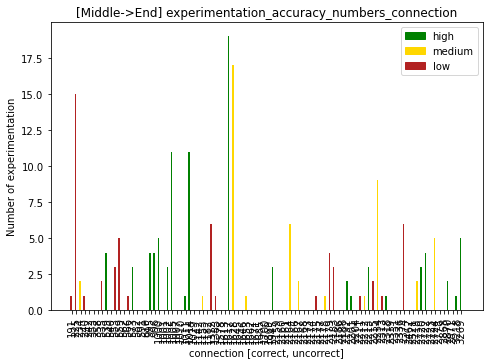

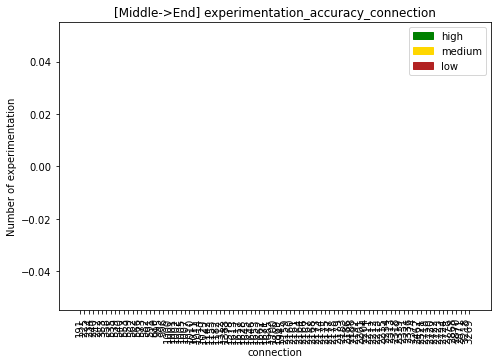

In [100]:
plotify_rate('[Middle->End] experimentation_accuracy_numbers_connection', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y, colors)
plotify('[Middle->End] experimentation_accuracy_connection', 'connection', 'Number of experimentation', nb_connection_1h, y_rate, colors)

#### validation_accuracy_connection

In [101]:
table = "validation"

In [102]:
experimentation_accuracy_connection_filter = dataframe_tables[table].query('id_connexion in {} and experimentation == 0'.format(nb_connection_1h))

 > Total

In [103]:
y = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter, 0, nb_connection_1h)
y_rate = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y]

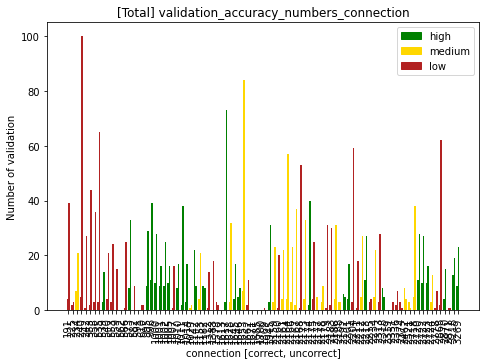

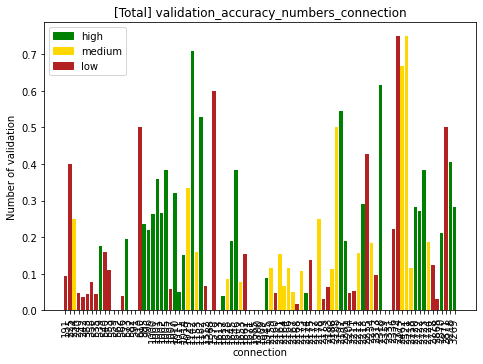

In [104]:
plotify_rate('[Total] validation_accuracy_numbers_connection', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y, colors)
plotify('[Total] validation_accuracy_numbers_connection', 'connection', 'Number of validation', nb_connection_1h, y_rate, colors)

 > Middle Prompt

In [105]:
y = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter, 1, nb_connection_1h)
y_rate = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y]

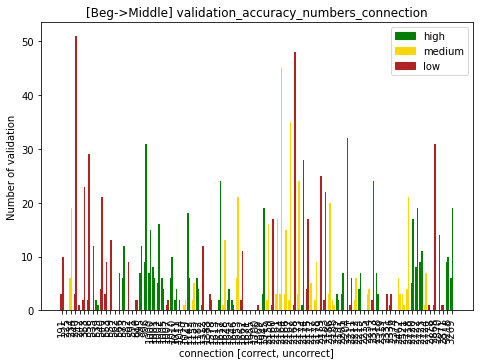

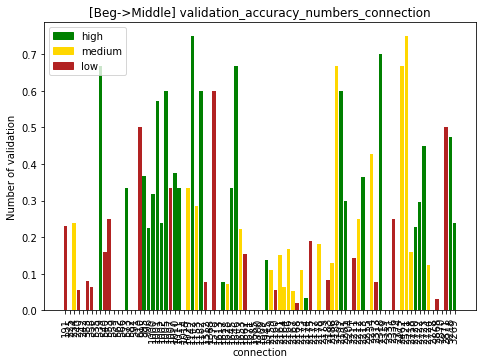

In [106]:
plotify_rate('[Beg->Middle] validation_accuracy_numbers_connection', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y, colors)
plotify('[Beg->Middle] validation_accuracy_numbers_connection', 'connection', 'Number of validation', nb_connection_1h, y_rate, colors)

 > Final Prompt

In [107]:
y = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter, 2, nb_connection_1h)
y_rate = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y]

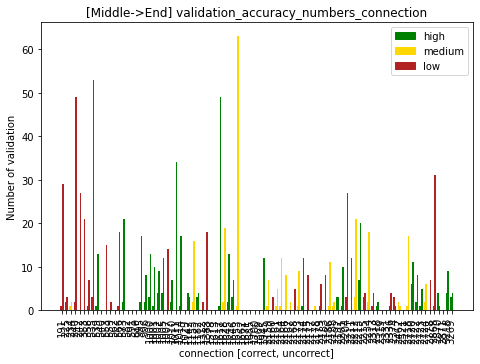

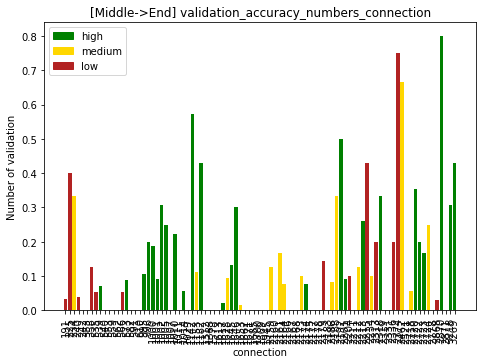

In [108]:
plotify_rate('[Middle->End] validation_accuracy_numbers_connection', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y, colors)
plotify('[Middle->End] validation_accuracy_numbers_connection', 'connection', 'Number of validation', nb_connection_1h, y_rate, colors)

#### experimentation_version_accuracy_connection

In [109]:
table = "validation"

In [110]:
experimentation_accuracy_connection_filter = dataframe_tables[table].query('id_connexion in {} and experimentation == 1'.format(nb_connection_1h))

 > Total

In [111]:
y1 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 1'), 0, nb_connection_1h)
y_rate1 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y1]
y2 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 2'), 0, nb_connection_1h)
y_rate2 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y2]
y3 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 3'), 0, nb_connection_1h)
y_rate3 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y3]
y4 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 4'), 0, nb_connection_1h)
y_rate4 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y4]

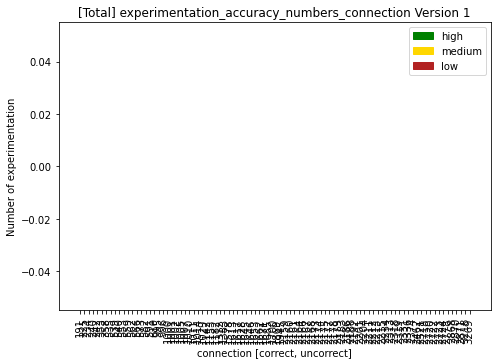

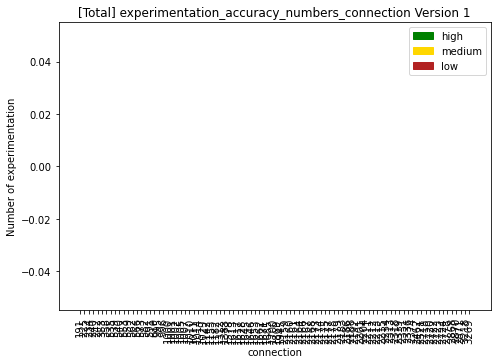

In [112]:
plotify_rate('[Total] experimentation_accuracy_numbers_connection Version 1', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y1, colors)
plotify('[Total] experimentation_accuracy_numbers_connection Version 1', 'connection', 'Number of experimentation', nb_connection_1h, y_rate1, colors)

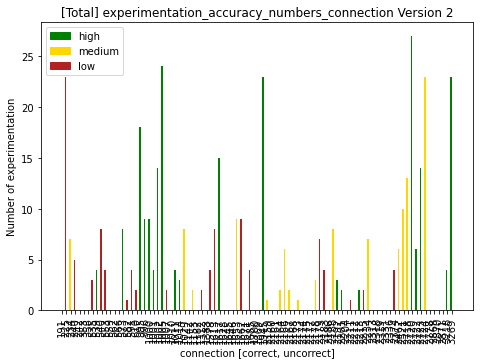

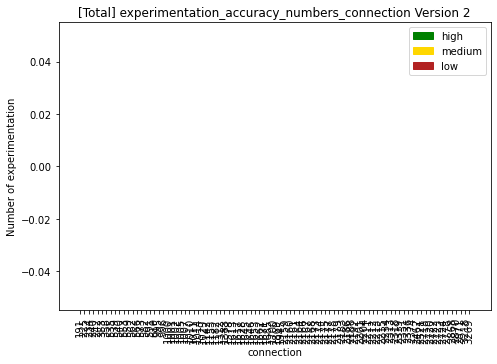

In [113]:
plotify_rate('[Total] experimentation_accuracy_numbers_connection Version 2', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y2, colors)
plotify('[Total] experimentation_accuracy_numbers_connection Version 2', 'connection', 'Number of experimentation', nb_connection_1h, y_rate2, colors)

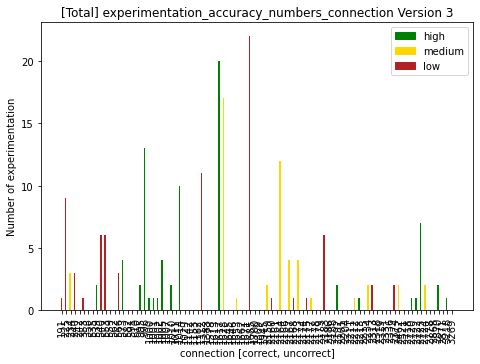

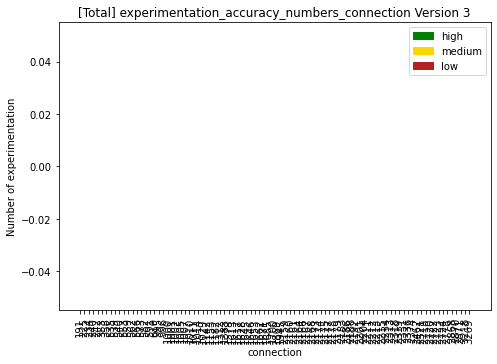

In [114]:
plotify_rate('[Total] experimentation_accuracy_numbers_connection Version 3', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y3, colors)
plotify('[Total] experimentation_accuracy_numbers_connection Version 3', 'connection', 'Number of experimentation', nb_connection_1h, y_rate3, colors)

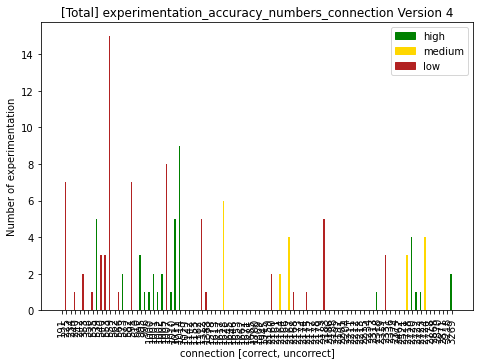

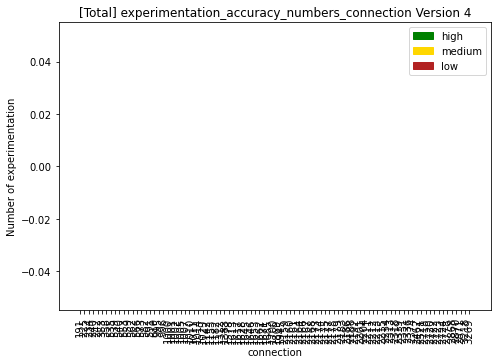

In [115]:
plotify_rate('[Total] experimentation_accuracy_numbers_connection Version 4', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y4, colors)
plotify('[Total] experimentation_accuracy_numbers_connection Version 4', 'connection', 'Number of experimentation', nb_connection_1h, y_rate4, colors)

 > Middle Prompt

In [116]:
y1 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 1'), 1, nb_connection_1h)
y_rate1 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y1]
y2 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 2'), 1, nb_connection_1h)
y_rate2 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y2]
y3 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 3'), 1, nb_connection_1h)
y_rate3 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y3]
y4 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 4'), 1, nb_connection_1h)
y_rate4 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y4]

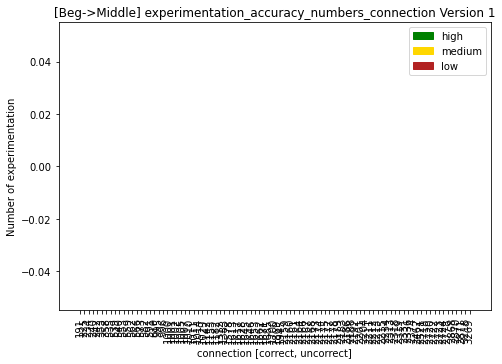

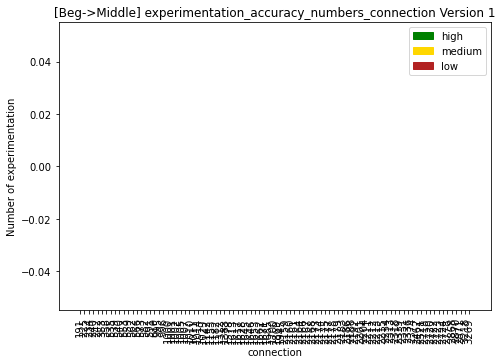

In [117]:
plotify_rate('[Beg->Middle] experimentation_accuracy_numbers_connection Version 1', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y1, colors)
plotify('[Beg->Middle] experimentation_accuracy_numbers_connection Version 1', 'connection', 'Number of experimentation', nb_connection_1h, y_rate1, colors)

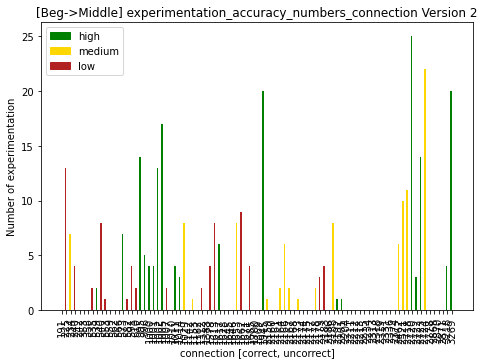

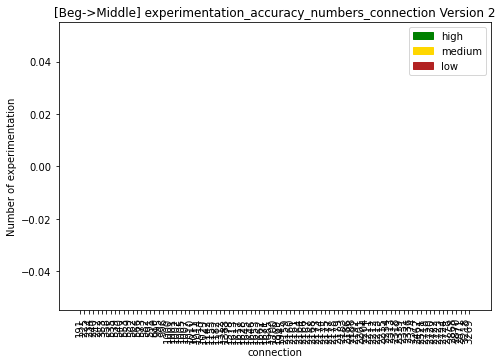

In [118]:
plotify_rate('[Beg->Middle] experimentation_accuracy_numbers_connection Version 2', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y2, colors)
plotify('[Beg->Middle] experimentation_accuracy_numbers_connection Version 2', 'connection', 'Number of experimentation', nb_connection_1h, y_rate2, colors)

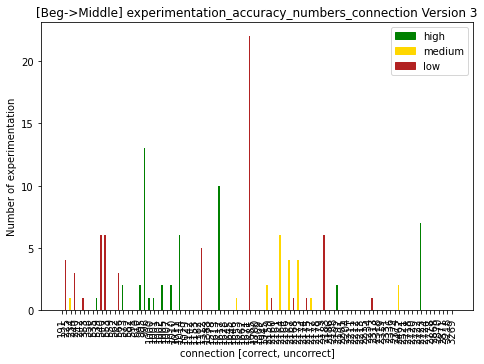

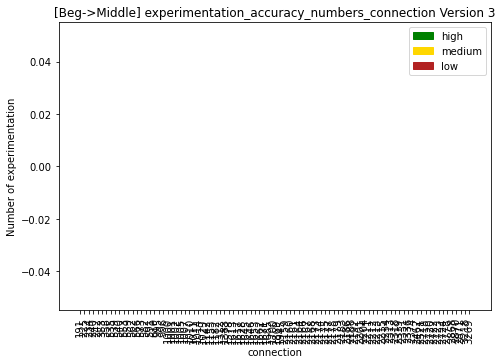

In [119]:
plotify_rate('[Beg->Middle] experimentation_accuracy_numbers_connection Version 3', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y3, colors)
plotify('[Beg->Middle] experimentation_accuracy_numbers_connection Version 3', 'connection', 'Number of experimentation', nb_connection_1h, y_rate3, colors)

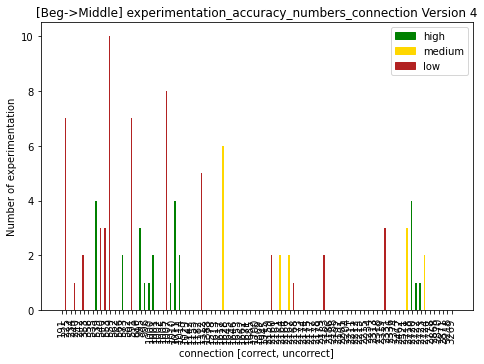

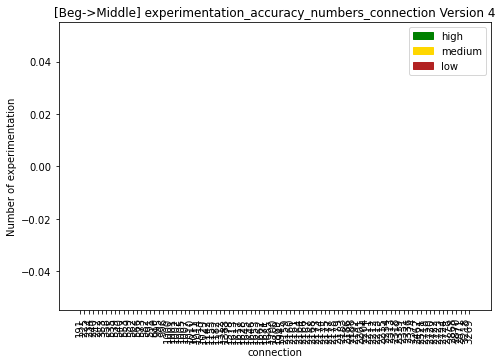

In [120]:
plotify_rate('[Beg->Middle] experimentation_accuracy_numbers_connection Version 4', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y4, colors)
plotify('[Beg->Middle] experimentation_accuracy_numbers_connection Version 4', 'connection', 'Number of experimentation', nb_connection_1h, y_rate4, colors)

 > Final Prompt

In [121]:
y1 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 1'), 2, nb_connection_1h)
y_rate1 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y1]
y2 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 2'), 2, nb_connection_1h)
y_rate2 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y2]
y3 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 3'), 2, nb_connection_1h)
y_rate3 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y3]
y4 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 4'), 2, nb_connection_1h)
y_rate4 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y4]

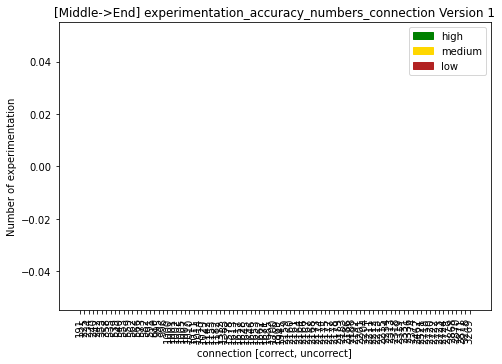

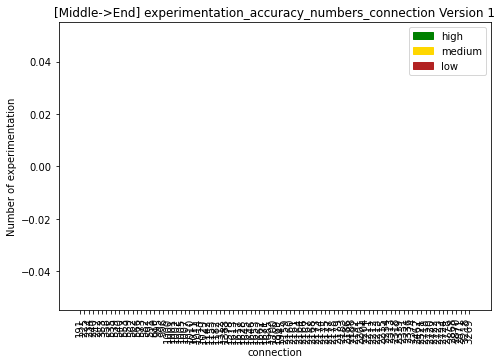

In [122]:
plotify_rate('[Middle->End] experimentation_accuracy_numbers_connection Version 1', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y1, colors)
plotify('[Middle->End] experimentation_accuracy_numbers_connection Version 1', 'connection', 'Number of experimentation', nb_connection_1h, y_rate1, colors)

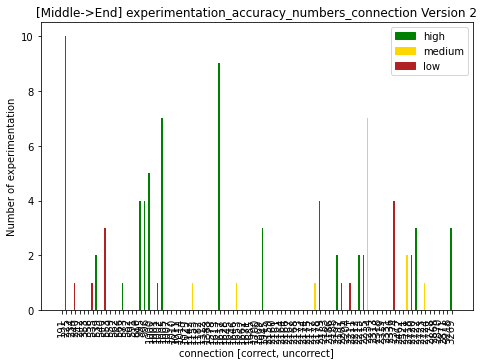

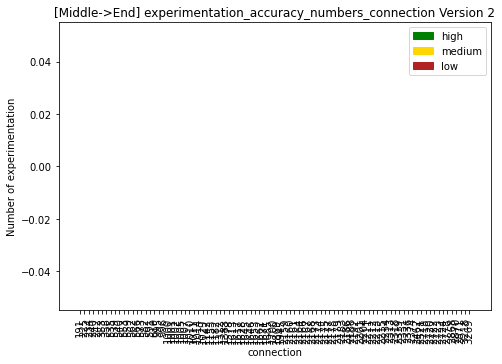

In [123]:
plotify_rate('[Middle->End] experimentation_accuracy_numbers_connection Version 2', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y2, colors)
plotify('[Middle->End] experimentation_accuracy_numbers_connection Version 2', 'connection', 'Number of experimentation', nb_connection_1h, y_rate2, colors)

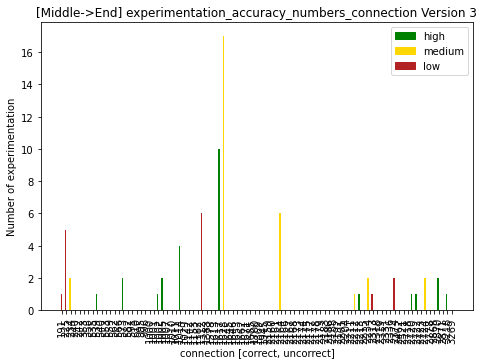

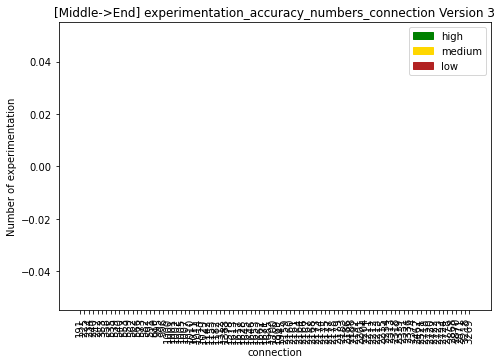

In [124]:
plotify_rate('[Middle->End] experimentation_accuracy_numbers_connection Version 3', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y3, colors)
plotify('[Middle->End] experimentation_accuracy_numbers_connection Version 3', 'connection', 'Number of experimentation', nb_connection_1h, y_rate3, colors)

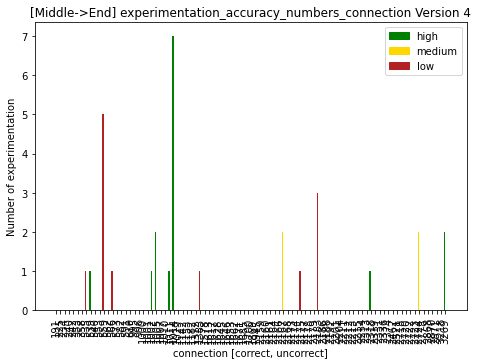

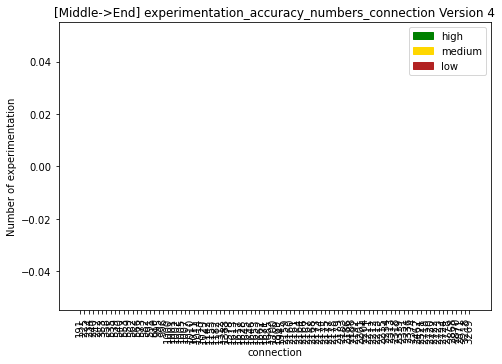

In [125]:
plotify_rate('[Middle->End] experimentation_accuracy_numbers_connection Version 4', 'connection [correct, uncorrect]', 'Number of experimentation', nb_connection_1h, y4, colors)
plotify('[Middle->End] experimentation_accuracy_numbers_connection Version 4', 'connection', 'Number of experimentation', nb_connection_1h, y_rate4, colors)

#### validation_version_accuracy_connection

In [126]:
table = "validation"

In [127]:
experimentation_accuracy_connection_filter = dataframe_tables[table].query('id_connexion in {} and experimentation == 0'.format(nb_connection_1h))

 > Total

In [128]:
y1 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 1'), 0, nb_connection_1h)
y_rate1 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y1]
y2 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 2'), 0, nb_connection_1h)
y_rate2 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y2]
y3 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 3'), 0, nb_connection_1h)
y_rate3 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y3]
y4 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 4'), 0, nb_connection_1h)
y_rate4 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y4]

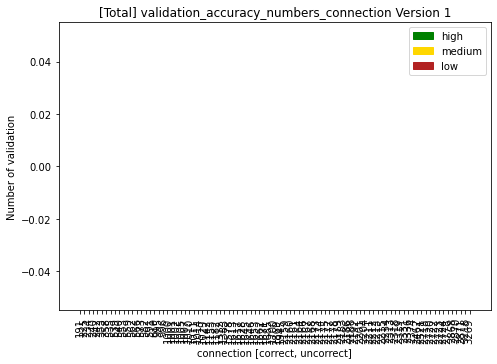

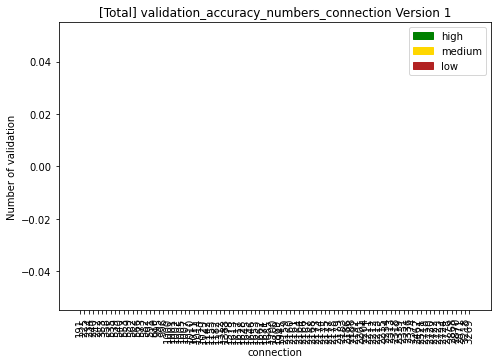

In [129]:
plotify_rate('[Total] validation_accuracy_numbers_connection Version 1', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y1, colors)
plotify('[Total] validation_accuracy_numbers_connection Version 1', 'connection', 'Number of validation', nb_connection_1h, y_rate1, colors)

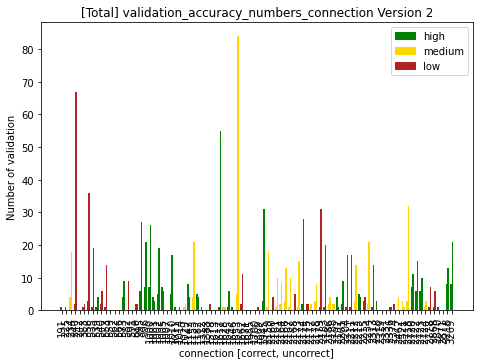

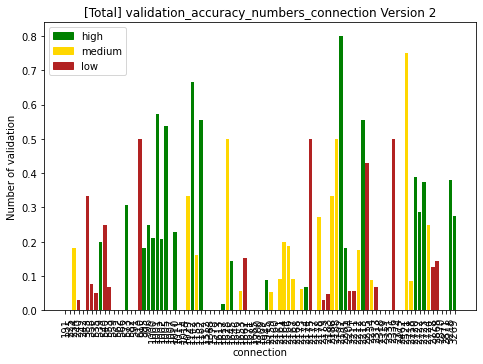

In [130]:
plotify_rate('[Total] validation_accuracy_numbers_connection Version 2', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y2, colors)
plotify('[Total] validation_accuracy_numbers_connection Version 2', 'connection', 'Number of validation', nb_connection_1h, y_rate2, colors)

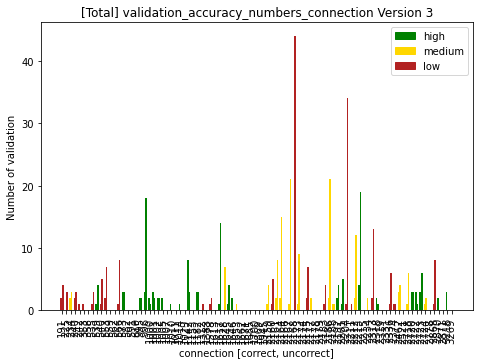

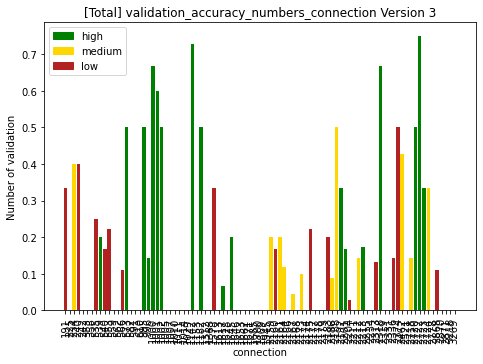

In [131]:
plotify_rate('[Total] validation_accuracy_numbers_connection Version 3', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y3, colors)
plotify('[Total] validation_accuracy_numbers_connection Version 3', 'connection', 'Number of validation', nb_connection_1h, y_rate3, colors)

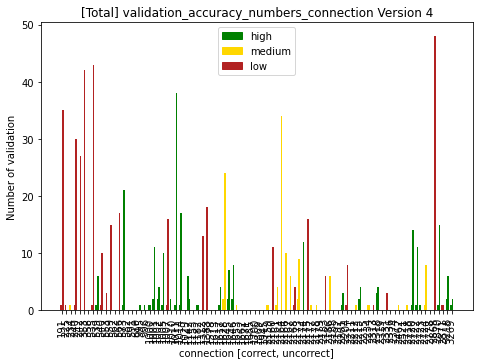

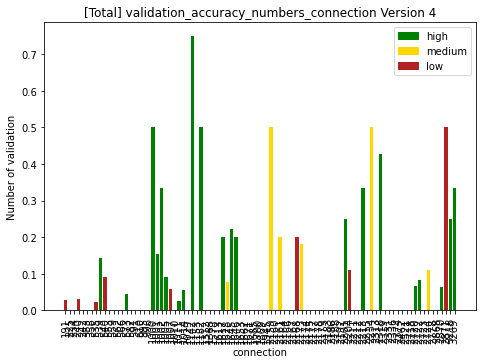

In [132]:
plotify_rate('[Total] validation_accuracy_numbers_connection Version 4', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y4, colors)
plotify('[Total] validation_accuracy_numbers_connection Version 4', 'connection', 'Number of validation', nb_connection_1h, y_rate4, colors)

 > Middle Prompt

In [133]:
y1 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 1'), 1, nb_connection_1h)
y_rate1 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y1]
y2 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 2'), 1, nb_connection_1h)
y_rate2 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y2]
y3 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 3'), 1, nb_connection_1h)
y_rate3 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y3]
y4 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 4'), 1, nb_connection_1h)
y_rate4 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y4]

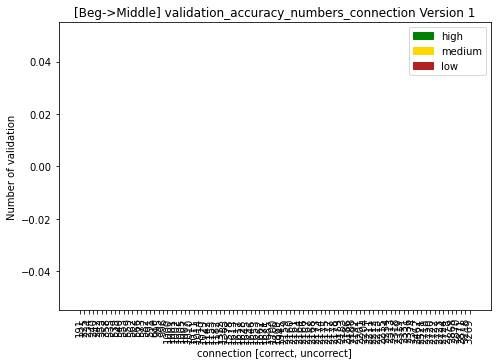

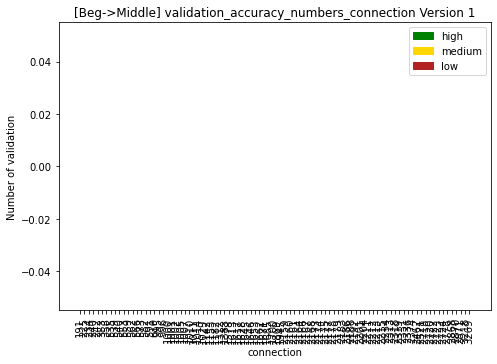

In [134]:
plotify_rate('[Beg->Middle] validation_accuracy_numbers_connection Version 1', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y1, colors)
plotify('[Beg->Middle] validation_accuracy_numbers_connection Version 1', 'connection', 'Number of validation', nb_connection_1h, y_rate1, colors)

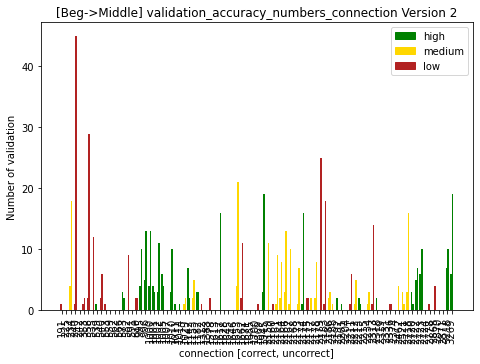

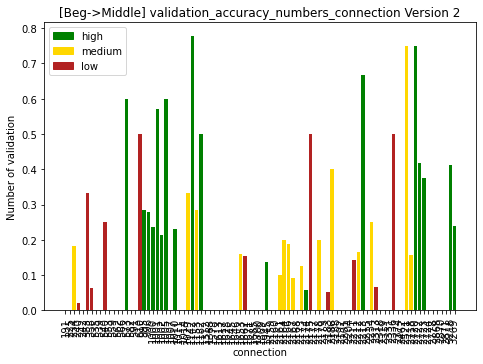

In [135]:
plotify_rate('[Beg->Middle] validation_accuracy_numbers_connection Version 2', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y2, colors)
plotify('[Beg->Middle] validation_accuracy_numbers_connection Version 2', 'connection', 'Number of validation', nb_connection_1h, y_rate2, colors)

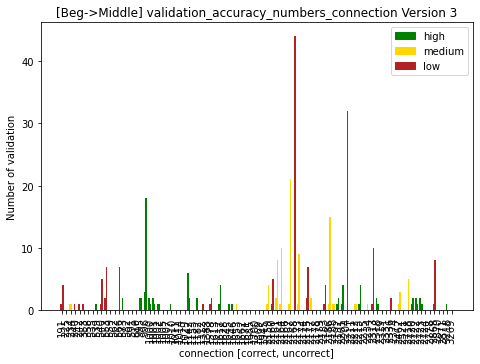

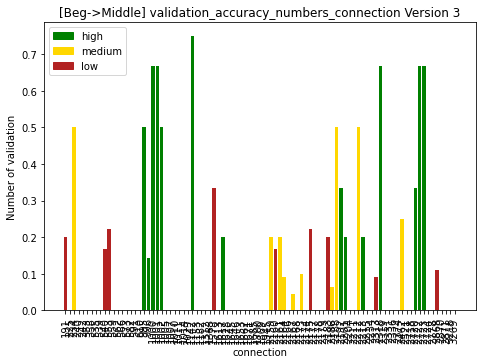

In [136]:
plotify_rate('[Beg->Middle] validation_accuracy_numbers_connection Version 3', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y3, colors)
plotify('[Beg->Middle] validation_accuracy_numbers_connection Version 3', 'connection', 'Number of validation', nb_connection_1h, y_rate3, colors)

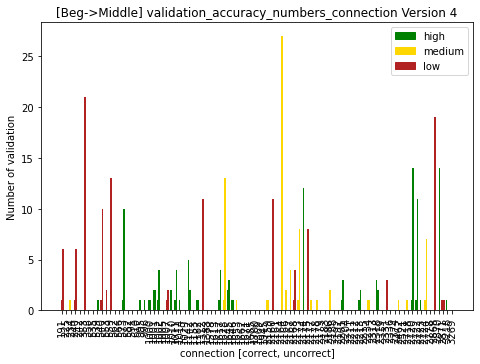

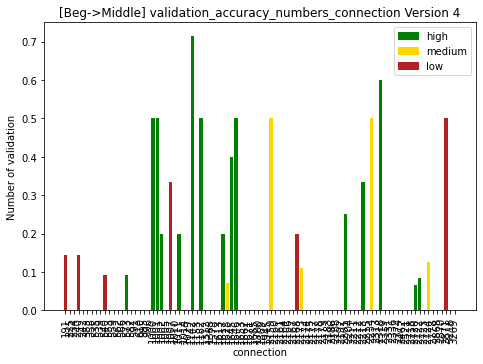

In [137]:
plotify_rate('[Beg->Middle] validation_accuracy_numbers_connection Version 4', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y4, colors)
plotify('[Beg->Middle] validation_accuracy_numbers_connection Version 4', 'connection', 'Number of validation', nb_connection_1h, y_rate4, colors)

 > Final Prompt

In [138]:
y1 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 1'), 2, nb_connection_1h)
y_rate1 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y1]
y2 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 2'), 2, nb_connection_1h)
y_rate2 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y2]
y3 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 3'), 2, nb_connection_1h)
y_rate3 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y3]
y4 = count_by_exp_acc_connection_and_prompts(experimentation_accuracy_connection_filter.query('version == 4'), 2, nb_connection_1h)
y_rate4 = [i[0] / (i[1] + i[0]) if i[1] != 0 and i[0] != 0 else 0 for i in y4]

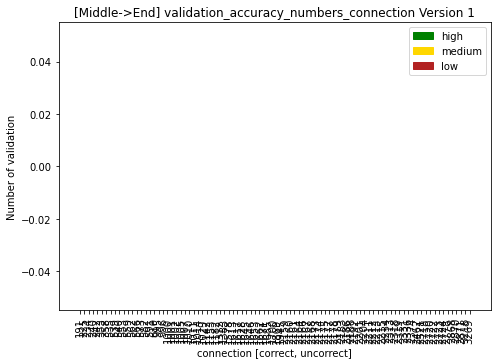

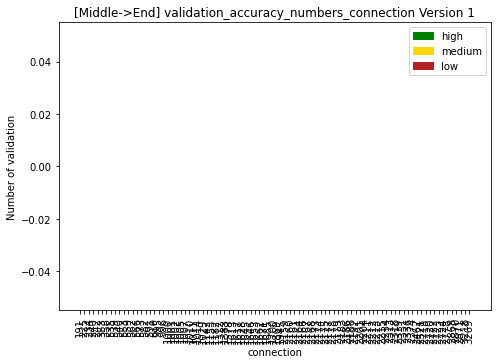

In [139]:
plotify_rate('[Middle->End] validation_accuracy_numbers_connection Version 1', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y1, colors)
plotify('[Middle->End] validation_accuracy_numbers_connection Version 1', 'connection', 'Number of validation', nb_connection_1h, y_rate1, colors)

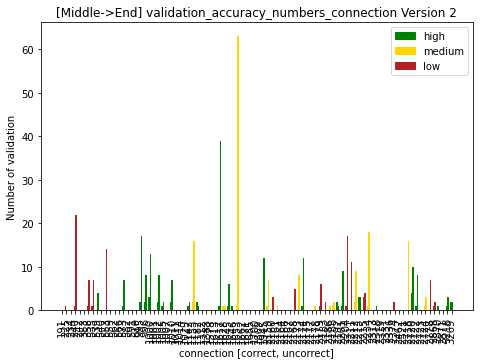

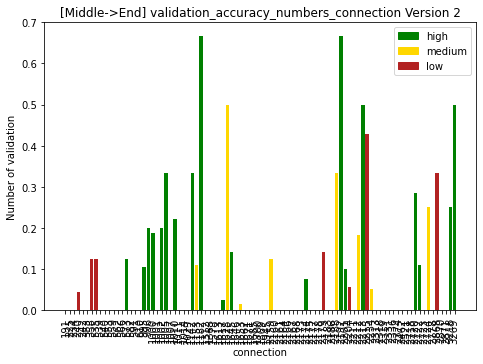

In [140]:
plotify_rate('[Middle->End] validation_accuracy_numbers_connection Version 2', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y2, colors)
plotify('[Middle->End] validation_accuracy_numbers_connection Version 2', 'connection', 'Number of validation', nb_connection_1h, y_rate2, colors)

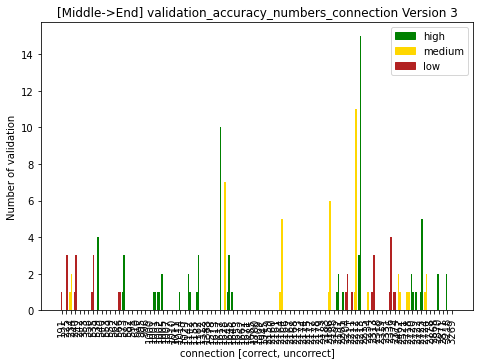

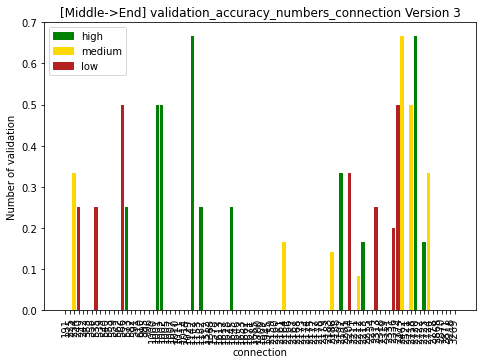

In [141]:
plotify_rate('[Middle->End] validation_accuracy_numbers_connection Version 3', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y3, colors)
plotify('[Middle->End] validation_accuracy_numbers_connection Version 3', 'connection', 'Number of validation', nb_connection_1h, y_rate3, colors)

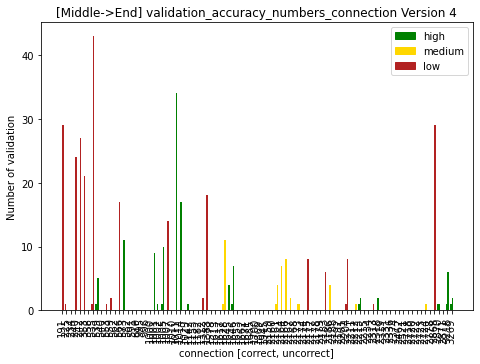

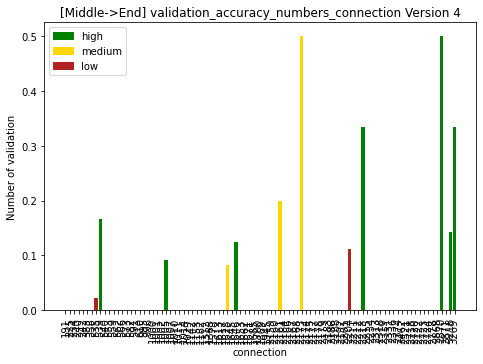

In [142]:
plotify_rate('[Middle->End] validation_accuracy_numbers_connection Version 4', 'connection [correct, uncorrect]', 'Number of validation', nb_connection_1h, y4, colors)
plotify('[Middle->End] validation_accuracy_numbers_connection Version 4', 'connection', 'Number of validation', nb_connection_1h, y_rate4, colors)

### Modification

#### nb_modification_connection

In [143]:
table = "modification"

In [144]:
nb_modification_connection_filter = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h))

 > Total

In [145]:
y = count_by_connection_and_prompts(nb_modification_connection_filter, 0, nb_connection_1h)

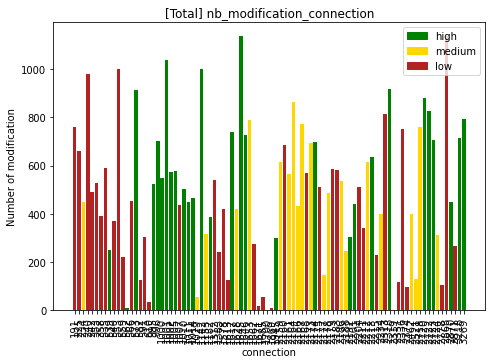

In [146]:
plotify('[Total] nb_modification_connection', 'connection', 'Number of modification', nb_connection_1h, y, colors)

 > Middle Prompt

In [147]:
y = count_by_connection_and_prompts(nb_modification_connection_filter, 1, nb_connection_1h)

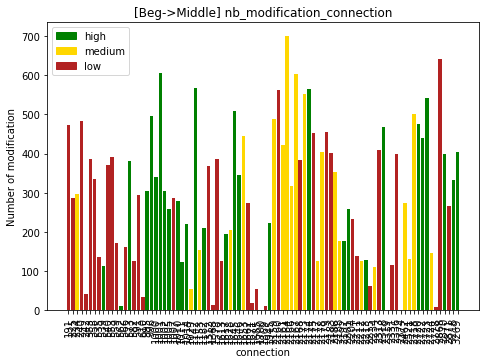

In [148]:
plotify('[Beg->Middle] nb_modification_connection', 'connection', 'Number of modification', nb_connection_1h, y, colors)

 > Final Prompt

In [149]:
y = count_by_connection_and_prompts(nb_modification_connection_filter, 2, nb_connection_1h)

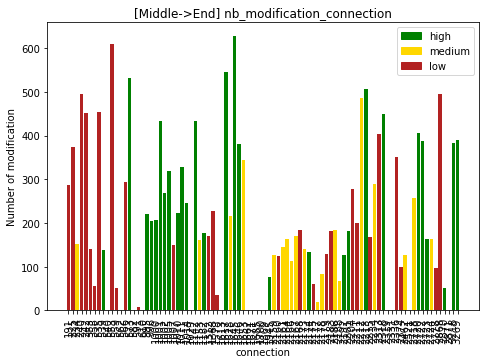

In [150]:
plotify('[Middle->End] nb_modification_connection', 'connection', 'Number of modification', nb_connection_1h, y, colors)

#### nb_modification_version_connection

In [151]:
table = "modification"

In [152]:
nb_modification_version_connection_filter_1 = dataframe_tables[table].query('id_connexion in {} and version == 1'.format(nb_connection_1h))
nb_modification_version_connection_filter_2 = dataframe_tables[table].query('id_connexion in {} and version == 2'.format(nb_connection_1h))
nb_modification_version_connection_filter_3 = dataframe_tables[table].query('id_connexion in {} and version == 3'.format(nb_connection_1h))
nb_modification_version_connection_filter_4 = dataframe_tables[table].query('id_connexion in {} and version == 4'.format(nb_connection_1h))

 > Total

In [153]:
y1 = count_by_connection_and_prompts(nb_modification_version_connection_filter_1, 0, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_modification_version_connection_filter_2, 0, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_modification_version_connection_filter_3, 0, nb_connection_1h)
y4 = count_by_connection_and_prompts(nb_modification_version_connection_filter_4, 0, nb_connection_1h)

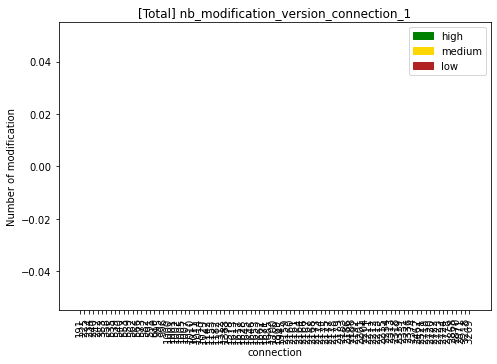

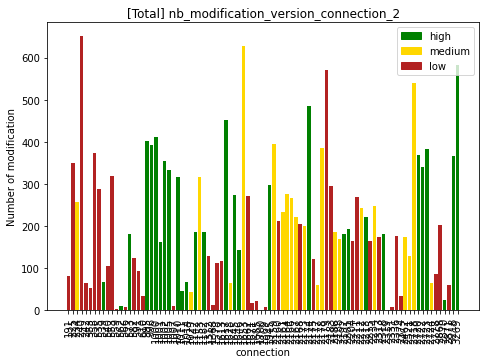

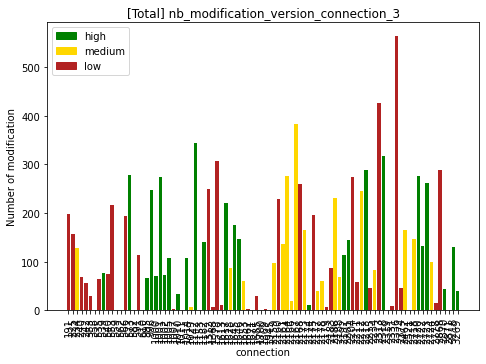

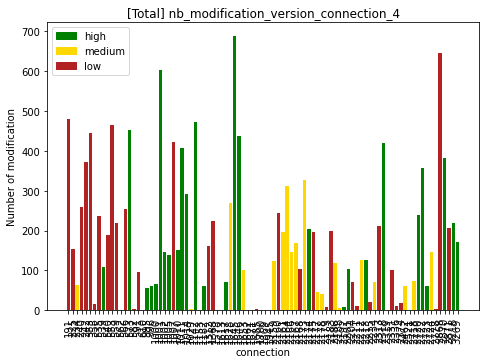

In [154]:
plotify('[Total] nb_modification_version_connection_1', 'connection', 'Number of modification', nb_connection_1h, y1, colors)
plotify('[Total] nb_modification_version_connection_2', 'connection', 'Number of modification', nb_connection_1h, y2, colors)
plotify('[Total] nb_modification_version_connection_3', 'connection', 'Number of modification', nb_connection_1h, y3, colors)
plotify('[Total] nb_modification_version_connection_4', 'connection', 'Number of modification', nb_connection_1h, y4, colors)

 > Middle Prompt

In [155]:
y1 = count_by_connection_and_prompts(nb_modification_version_connection_filter_1, 1, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_modification_version_connection_filter_2, 1, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_modification_version_connection_filter_3, 1, nb_connection_1h)
y4 = count_by_connection_and_prompts(nb_modification_version_connection_filter_4, 1, nb_connection_1h)

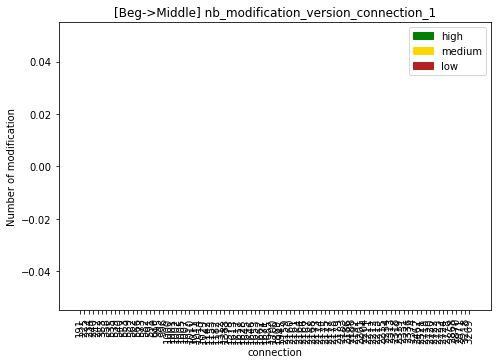

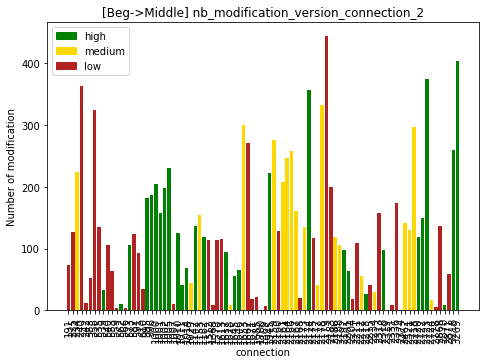

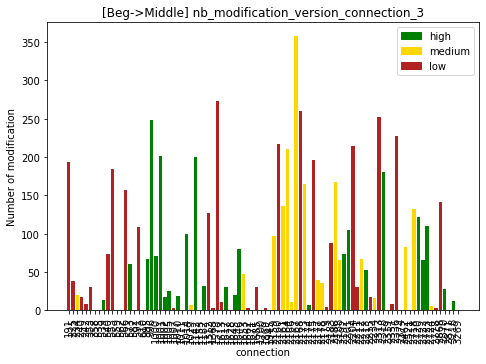

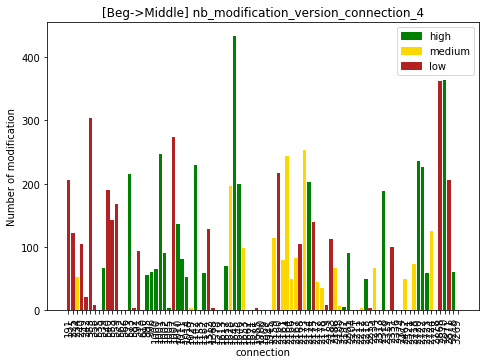

In [156]:
plotify('[Beg->Middle] nb_modification_version_connection_1', 'connection', 'Number of modification', nb_connection_1h, y1, colors)
plotify('[Beg->Middle] nb_modification_version_connection_2', 'connection', 'Number of modification', nb_connection_1h, y2, colors)
plotify('[Beg->Middle] nb_modification_version_connection_3', 'connection', 'Number of modification', nb_connection_1h, y3, colors)
plotify('[Beg->Middle] nb_modification_version_connection_4', 'connection', 'Number of modification', nb_connection_1h, y4, colors)

 > Final Prompt

In [157]:
y1 = count_by_connection_and_prompts(nb_modification_version_connection_filter_1, 2, nb_connection_1h)
y2 = count_by_connection_and_prompts(nb_modification_version_connection_filter_2, 2, nb_connection_1h)
y3 = count_by_connection_and_prompts(nb_modification_version_connection_filter_3, 2, nb_connection_1h)
y4 = count_by_connection_and_prompts(nb_modification_version_connection_filter_4, 2, nb_connection_1h)

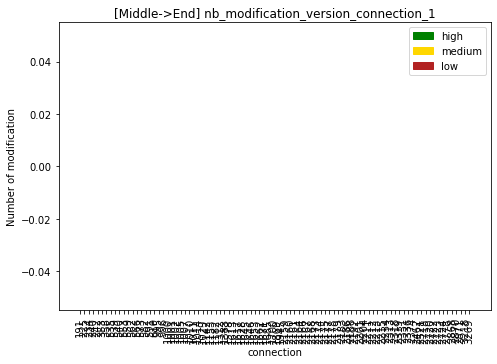

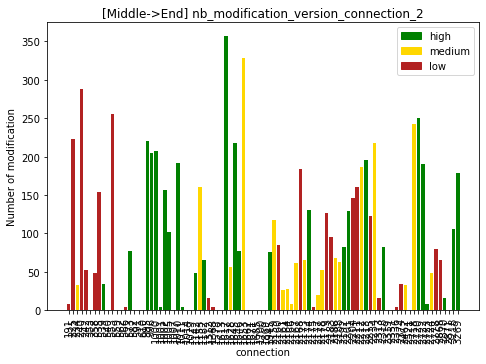

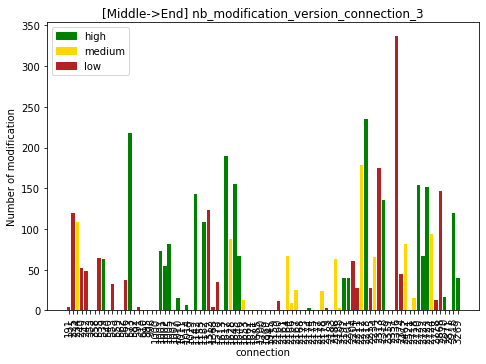

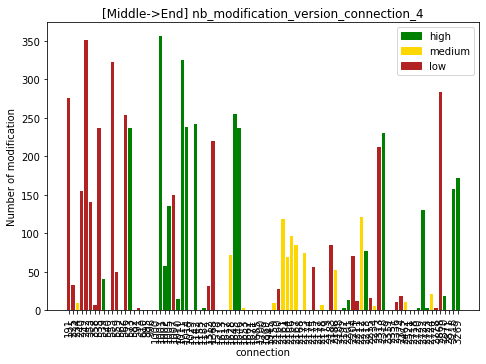

In [158]:
plotify('[Middle->End] nb_modification_version_connection_1', 'connection', 'Number of modification', nb_connection_1h, y1, colors)
plotify('[Middle->End] nb_modification_version_connection_2', 'connection', 'Number of modification', nb_connection_1h, y2, colors)
plotify('[Middle->End] nb_modification_version_connection_3', 'connection', 'Number of modification', nb_connection_1h, y3, colors)
plotify('[Middle->End] nb_modification_version_connection_4', 'connection', 'Number of modification', nb_connection_1h, y4, colors)

### Pas à Pas

#### nb_pasapas_connection

In [159]:
table = "pas_a_pas"

In [160]:
nb_pasapas_connection_filter = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h))

 > Total

In [161]:
y = count_by_connection_and_prompts(nb_pasapas_connection_filter, 0, nb_connection_1h) 

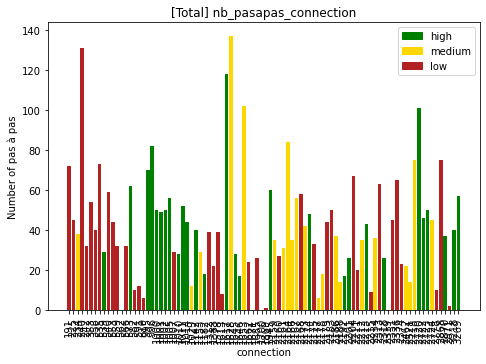

In [162]:
plotify('[Total] nb_pasapas_connection', 'connection', 'Number of pas à pas', nb_connection_1h, y, colors)

 > Middle Prompt

In [163]:
y = count_by_connection_and_prompts(nb_pasapas_connection_filter, 1, nb_connection_1h) 

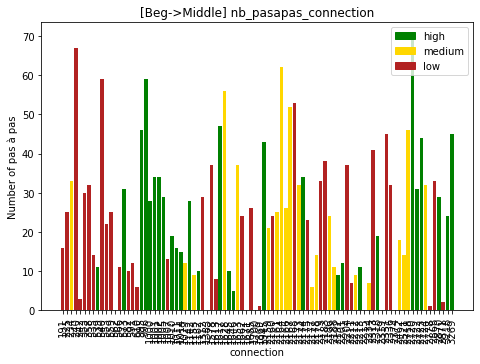

In [164]:
plotify('[Beg->Middle] nb_pasapas_connection', 'connection', 'Number of pas à pas', nb_connection_1h, y, colors)

 > Final Prompt

In [165]:
y = count_by_connection_and_prompts(nb_pasapas_connection_filter, 2, nb_connection_1h) 

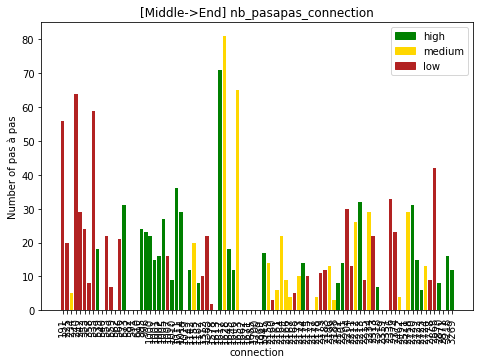

In [166]:
plotify('[Middle->End] nb_pasapas_connection', 'connection', 'Number of pas à pas', nb_connection_1h, y, colors)

## Visualization of Prompts

### Initial Prompt

#### quickpi_knowledge_participant

In [167]:
table = "srl_initial_prompt"

In [168]:
quickpi_knowledge = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

NameError: ignored

#### coding_knowledge_participant

In [ ]:
table = "srl_initial_prompt"

In [ ]:
coding_knowledge = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

#### autonomy_participant

In [ ]:
table = "srl_initial_prompt"

In [ ]:
autonomy = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

#### place_participant

In [ ]:
table = "srl_initial_prompt"

In [ ]:
place = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

#### engagement_participant

In [ ]:
table = "srl_initial_prompt"

In [ ]:
engagement = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

#### initial_objective_participant

In [ ]:
table = "srl_initial_prompt"

In [ ]:
initial_objectif = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

### Middle Prompt

#### motivation_participant

In [ ]:
table = "srl_prompt"

In [ ]:
motivation = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

#### middle_time_management_participant

In [ ]:
table = "srl_prompt"

In [ ]:
middle_time_management = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

#### middle_objective_participant

In [ ]:
table = "srl_prompt"

In [ ]:
middle_objective = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

#### new_objective_participant

In [ ]:
table = "srl_prompt"

In [ ]:
new_objective = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

### Final Prompt

#### final_time_management_participant

In [ ]:
table = "srl_final_prompt"

In [ ]:
initial_objectif = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

#### strategy_participant

In [ ]:
table = "srl_final_prompt"

In [ ]:
initial_objectif = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))

#### end_objective_participant

In [ ]:
table = "srl_final_prompt"

In [ ]:
initial_objectif = dataframe_tables[table].query('id_connexion in {}'.format(nb_connection_1h_prompts))